In [1]:
import numpy as np
import xarray as xr
import xrft
import gsw
import os.path as op
import dask.array.fft as fft
from dask.diagnostics import ProgressBar
from oceanmodes import instability_analysis_from_N2_profile as insta
from oceanmodes import neutral_modes_from_N2_profile as neu
from scipy.interpolate import PchipInterpolator as pchip
from scipy.stats import norm, gaussian_kde
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from matplotlib.gridspec import GridSpec as GS
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [2]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs/'
takadir = '/swot/SUM02/takaya/channelMOC-Darwin/'
avisodir = '/swot/SUM03/avisoftp.cnes.fr/AVISO/pub/jason-2/gdr_d'

In [3]:
ys, dy = (132,1)
dt = 150
# df = 288
ts = int(360*86400*(ys+.0)/dt)
te = int(ts+360*86400*dy/dt)
print(ts,te)

27371520 27578880


In [4]:
f0 = -1.1e-4
beta = 1.4e-11
g = 9.81
r0 = 1e3
alpha = 2e-4

In [6]:
# dTtave = open_mdsdataset(op.join(ddir,'02km_taveDef'), 
# #                         grid_dir=op.join(ddir,'02km_grid'),
#                         iters=range(ts+25920,te+25920,25920), 
#                         prefix=['Ttave'], delta_t=dt
#                         )
# dTtave

In [6]:
# dTtave.Ttave.mean(['time','XC']).plot()

In [8]:
# dTtave.Ttave[:,0].mean(['YC','XC']).plot()

In [5]:
dsmom = open_mdsdataset(op.join(takadir, '05km_t150'), 
                       grid_dir=op.join(ddir,'5km_grid'),
                       iters=range(ts,te+8640,8640), 
                       prefix=['W','PH',
                              'U','V'], delta_t=dt
                       )
dsmom

<xarray.Dataset>
Dimensions:  (XC: 200, XG: 200, YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 25)
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 ... 987500.0 992500.0 997500.0
  * YC       (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 ... 985000.0 990000.0 995000.0
  * YG       (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 ... -2625.955 -2757.325 -2912.665
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 ... -2689.32 -2825.33 -3000.0
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 ... -2689.32 -2825.33 -3000.0
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 ... -2562.59 -2689.32 -2825.33
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dxG      (YG, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dyG      (YC, XG) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC, XC) >f4 dask.array<

In [8]:
# dsmom_chunked = dsmom.chunk({'Z':1,'Zl':1,'Zp1':1})
# dsmom_chunked

<xarray.Dataset>
Dimensions:  (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 25)
Coordinates:
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 ... 995000.0 997000.0 999000.0
  * YC       (YC) >f4 1000.0 3000.0 5000.0 ... 1995000.0 1997000.0 1999000.0
  * XG       (XG) >f4 0.0 2000.0 4000.0 6000.0 ... 994000.0 996000.0 998000.0
  * YG       (YG) >f4 0.0 2000.0 4000.0 6000.0 ... 1994000.0 1996000.0 1998000.0
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 ... -2625.955 -2757.325 -2912.665
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 ... -2689.32 -2825.33 -3000.0
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 ... -2689.32 -2825.33 -3000.0
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 ... -2562.59 -2689.32 -2825.33
    rA       (YC, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dxG      (YG, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dyG      (YC, XG) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    Depth    (YC, XC

In [22]:
dsmom.to_zarr(op.join(ddir,'../zarr'), consolidated=True, mode='w')

In [7]:
import gcsfs

In [13]:
base_path = 'pangeo-data/'
path = base_path + 'takaya/MITgcm-channel-flatbottom-02km-run01/'
test = xr.open_zarr(gcsfs.GCSMap(path))
test

_call out of retries on exception: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/service-accounts/default/?recursive=true (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6f09993e48>: Failed to establish a new connection: [Errno -2] Name or service not known',))
Traceback (most recent call last):
  File "/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/urllib3/util/connection.py", line 56, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/takaya/miniconda3/envs/uptodate/lib/python3.6/socket.py", line 745, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -2] Name o

<xarray.Dataset>
Dimensions:  (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 25)
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    PHrefC   (Z) float32 dask.array<shape=(76,), chunksize=(76,)>
    PHrefF   (Zp1) float32 dask.array<shape=(77,), chunksize=(77,)>
  * XC       (XC) float32 1000.0 3000.0 5000.0 ... 995000.0 997000.0 999000.0
  * XG       (XG) float32 0.0 2000.0 4000.0 ... 994000.0 996000.0 998000.0
  * YC       (YC) float32 1000.0 3000.0 5000.0 ... 1995000.0 1997000.0 1999000.0
  * YG       (YG) float32 0.0 2000.0 4000.0 ... 1994000.0 1996000.0 1998000.0
  * Z        (Z) float32 -0.5 -1.57 -2.79 ... -2625.955 -2757.325 -2912.665
  * Zl       (Zl) float32 0.0 -1.0 -2.14 -3.44 ... -2562.59 -2689.32 -2825.33
  * Zp1      (Zp1) float32 0.0 -1.0 -2.14 -3.44 ... -2689.32 -2825.33 -3000.0
  * Zu       (Zu) float32 -1.0 -2.14 -3.44 -4.93 ... -2689.32 -2825.33 -3000.0
    drC      (Zp1) float64 dask.arra

In [20]:
dsmon = open_mdsdataset(op.join(takadir, '05km_t150'), 
                       grid_dir=op.join(ddir,'5km_grid'),
                       iters=range(ts+int(2*8640),te+int(2*8640),int(2*8640)), 
                       prefix=['wVeltave','PhHytave','Ttave',
                              'uVeltave','vVeltave'], 
                       delta_t=dt
                       )
dsmon

<xarray.Dataset>
Dimensions:   (XC: 200, XG: 200, YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 12)
Coordinates:
  * XC        (XC) >f4 2500.0 7500.0 12500.0 ... 987500.0 992500.0 997500.0
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG        (XG) >f4 0.0 5000.0 10000.0 15000.0 ... 985000.0 990000.0 995000.0
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Z         (Z) >f4 -0.5 -1.57 -2.79 -4.185 ... -2625.955 -2757.325 -2912.665
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.14 -3.44 ... -2689.32 -2825.33 -3000.0
  * Zu        (Zu) >f4 -1.0 -2.14 -3.44 -4.93 ... -2689.32 -2825.33 -3000.0
  * Zl        (Zl) >f4 0.0 -1.0 -2.14 -3.44 ... -2562.59 -2689.32 -2825.33
    rA        (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dxG       (YG, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dyG       (YC, XG) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth     (YC, XC) >f

In [13]:
dsmon.PhHytave

<xarray.DataArray 'PhHytave' (time: 12, Z: 76, YC: 400, XC: 200)>
dask.array<shape=(12, 76, 400, 200), dtype=float32, chunksize=(1, 76, 400, 200)>
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 ... 987500.0 992500.0 997500.0
  * YC       (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 ... -2625.955 -2757.325 -2912.665
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    drF      (Z) >f4 dask.array<shape=(76,), chunksize=(76,)>
    PHrefC   (Z) >f4 dask.array<shape=(76,), chunksize=(76,)>
    hFacC    (Z, YC, XC) >f4 dask.array<shape=(76, 400, 200), chunksize=(76, 400, 200)>
    iter     (time) int64 dask.array<shape=(12,), chunksize=(1,)>
  * time     (time) int64 4108320000 4110912000 ... 4134240000 4136832000
Attributes:
    standard_name:  sea_water_dynamic_pressue
    long_name:      Hydrostatic Pressure Pot

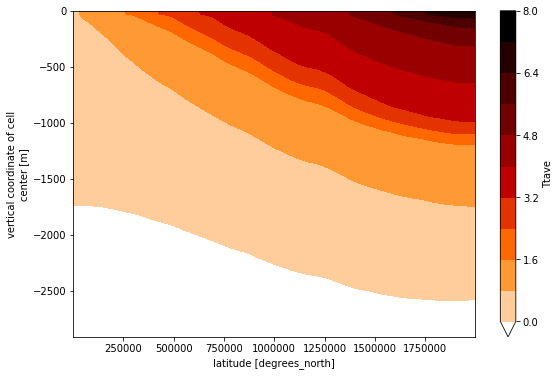

In [16]:
dsmon.Ttave.mean(['time','XC']).plot.contourf(figsize=(9,6), levels=np.linspace(0,8,11),
                                             cmap='gist_heat_r')

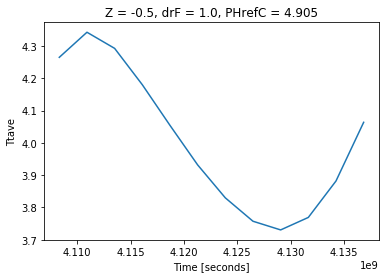

In [22]:
dsmon.Ttave[:,0].mean(['YC','XC']).plot()

In [23]:
Tave = dsmon.Ttave.mean(['XC'])
with ProgressBar():
    hT = 2*((Tave.mean('time')*dsmon.Z*dsmon.drF).sum('Z')/(Tave.mean('time')*dsmon.drF).sum('Z')).compute()
hT

[########################################] | 100% Completed |  2.4s


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/dask/local.py:253: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<xarray.DataArray (YC: 1000)>
array([        nan,   276.9952 ,   275.96194, ..., -1439.361  , -1439.2227 ,
       -1439.1919 ], dtype=float32)
Coordinates:
  * YC       (YC) >f4 1000.0 3000.0 5000.0 ... 1995000.0 1997000.0 1999000.0

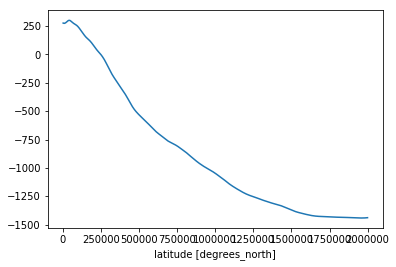

In [93]:
hT.plot()

## $$u_c = \frac{g\alpha}{f}\int_0^{L_y}\int_{-H}^0 z\frac{\partial\langle\theta\rangle}{\partial y} dz\ dy$$

In [28]:
grid = Grid(dsmon, periodic=['X'])
uC = g*alpha * ((grid.diff(Tave * grid.interp(dsmon.dxC,'X').mean('XC'),
                          'Y',boundary='fill')*dsmon.rAs.mean('XC')**-1 * dsmon.Z
                ).sum('Z') * dsmon.dyC.mean('XC')).sum('YG') * f0**-1
uC

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)


<xarray.DataArray (time: 12)>
dask.array<shape=(12,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) float64 1.426e+08 1.452e+08 ... 1.685e+08 1.711e+08

In [44]:
uB = np.abs(dsmon.Zp1[-1]) * (dsmon.uVeltave[:,-1]*dsmon.dyG).mean('XG').sum('YC')
uB

<xarray.DataArray (time: 12)>
dask.array<shape=(12,), dtype=float32, chunksize=(1,)>
Coordinates:
    Zp1      >f4 -3000.0
    drC      float64 dask.array<shape=(), chunksize=()>
    PHrefF   >f4 dask.array<shape=(), chunksize=()>
    Z        >f4 -2912.665
    drF      >f4 dask.array<shape=(), chunksize=()>
    PHrefC   >f4 dask.array<shape=(), chunksize=()>
    iter     (time) int64 dask.array<shape=(12,), chunksize=(1,)>
  * time     (time) float64 1.426e+08 1.452e+08 ... 1.685e+08 1.711e+08

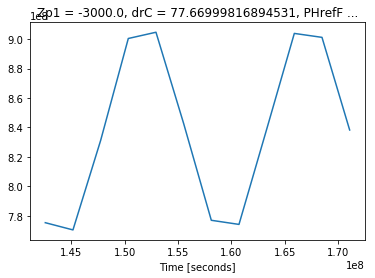

In [45]:
uB.plot()

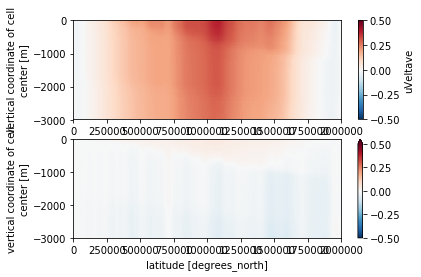

In [16]:
Uave = dsmon.uVeltave.mean(['XG'])
# Uanom = Uave - grid.interp(ug.mean('XC'), 'Y', boundary='fill')
# fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)
# Uave.mean('time').plot(ax=ax1, vmax=.5)
# Uanom.mean('time').plot(ax=ax2, vmax=.5)

In [17]:
with ProgressBar():
    uT = (Uave*dsmon.drF*dsmon.dyG.mean(['XG'])).sum(['Z','YC']).compute()
# with ProgressBar():
#     uC = (uc*dsmon.drF*dsmon.dyG.mean(['XG'])).sum(['Z','YC']).compute()
uT

[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.0s


<xarray.DataArray (time: 12)>
array([3.351927e+08, 3.357936e+08, 3.661300e+08, 4.026525e+08, 4.031998e+08,
       3.714747e+08, 3.380542e+08, 3.390574e+08, 3.730216e+08, 4.089369e+08,
       4.064797e+08, 3.731360e+08], dtype=float32)
Coordinates:
    iter     (time) int64 3564000 3628800 3693600 ... 4147200 4212000 4276800
  * time     (time) float64 1.426e+08 1.452e+08 ... 1.685e+08 1.711e+08

[Text(1, 0, '91'),
 Text(1, 0, '91.5'),
 Text(1, 0, '92'),
 Text(1, 0, '92.5'),
 Text(1, 0, '93')]

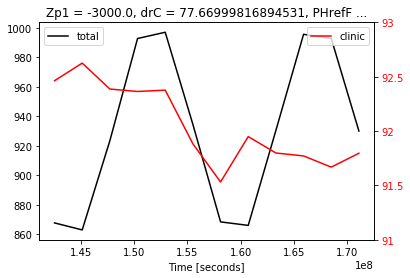

In [48]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
(uT[-12:]*1e-6).plot(ax=ax, c='k', label=r'total')
((uT-uB)[-12:]*1e-6).plot(ax=ax2, c='r', label=r'clinic')
ax2.legend(loc='upper right')
ax.legend(loc='upper left')
ax2.set_yticks([91,91.5,92,92.5,93])
ax2.set_yticklabels([91,91.5,92,92.5,93], color='r')

In [20]:
dsmon.to_zarr(op.join(ddir,'../zarr'), consolidated=True, mode='w')

In [21]:
test = xr.open_zarr(op.join(ddir,'../zarr/'), consolidated=True)
test

<xarray.Dataset>
Dimensions:   (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 12)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    PHrefC    (Z) float32 dask.array<shape=(76,), chunksize=(76,)>
    PHrefF    (Zp1) float32 dask.array<shape=(77,), chunksize=(77,)>
  * XC        (XC) float32 1000.0 3000.0 5000.0 ... 995000.0 997000.0 999000.0
  * XG        (XG) float32 0.0 2000.0 4000.0 ... 994000.0 996000.0 998000.0
  * YC        (YC) float32 1000.0 3000.0 5000.0 ... 1997000.0 1999000.0
  * YG        (YG) float32 0.0 2000.0 4000.0 ... 1994000.0 1996000.0 1998000.0
  * Z         (Z) float32 -0.5 -1.57 -2.79 ... -2625.955 -2757.325 -2912.665
  * Zl        (Zl) float32 0.0 -1.0 -2.14 -3.44 ... -2562.59 -2689.32 -2825.33
  * Zp1       (Zp1) float32 0.0 -1.0 -2.14 -3.44 ... -2689.32 -2825.33 -3000.0
  * Zu        (Zu) float32 -1.0 -2.14 -3.44 -4.93 ... -2689.32 -2825.33 -3000.0
    drC       (Zp1) float64 dask.a

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


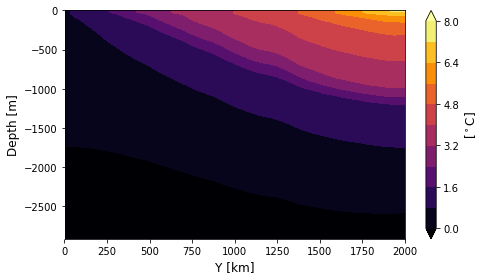

In [18]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
im = ax.contourf(dsmon.YC*1e-3, dsmon.Z, dsmon.Ttave.mean(['time','XC']), 
                levels=np.linspace(0,8,11), extend='both', cmap='inferno')
ax.set_xlabel(r"Y [km]", fontsize=12)
ax.set_ylabel(r"Depth [m]", fontsize=12)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"[$^\circ$C]", fontsize=12)
plt.savefig(op.join(takadir,'Figures/Stratification_05km.pdf'))

In [357]:
dsmon.PhHytave.attrs

OrderedDict([('standard_name', 'sea_water_dynamic_pressue'),
             ('long_name', 'Hydrostatic Pressure Pot.(p/rho) Anomaly'),
             ('units', 'm2 s-2')])

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


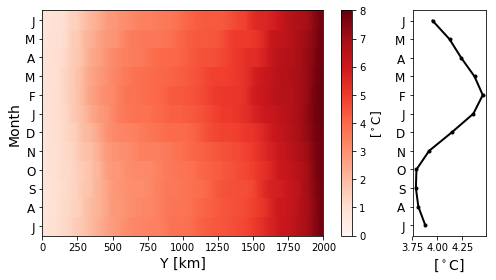

In [130]:
from matplotlib.gridspec import GridSpec as GS

fig = plt.figure(figsize=(7,4))
fig.set_tight_layout(True)
gs = GS(nrows=1,ncols=5)
ax1 = fig.add_subplot(gs[0,:-1])
ax2 = fig.add_subplot(gs[0,-1])
im = ax1.pcolormesh(dsmon.YC*1e-3, np.arange(0,13), dsmon.Ttave[:,0].roll(time=-0).mean('XC'),
                   cmap='Reds', vmin=0, vmax=8)
ax2.plot(dsmon.Ttave[:,0].sel(YC=slice(6e5,14e5)).roll(time=-0).mean(['YC','XC']), np.arange(.5,12.5), 'k.-', lw=2)
ax1.set_yticks(np.arange(.5,12.5))
ax1.set_yticklabels(np.roll(np.asarray(['J','F','M','A','M','J','J','A','S','O','N','D']),-6), fontsize=12)
ax2.set_yticks(np.arange(.5,12.5))
ax2.set_yticklabels(np.roll(np.asarray(['J','F','M','A','M','J','J','A','S','O','N','D']),-6), fontsize=12)
ax1.set_xlabel(r"Y [km]", fontsize=14)
ax1.set_ylabel(r"Month", fontsize=14)
ax2.set_xlabel(r"[$^\circ$C]", fontsize=14)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label(r"[$^\circ$C]", fontsize=12)
plt.savefig(op.join(ddir,'../Figures/SST_02km.pdf'))

In [7]:
dsday = open_mdsdataset(op.join(takadir, '05km_t150'), 
                       grid_dir=op.join(ddir,'5km_grid'),
                       iters=range(ts+576,te+576,576), 
                       prefix=['MOMtave'], delta_t=dt
                       )
dsday

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 360)
Coordinates:
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XG       (XG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * YG       (YG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dxG      (YG, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dyG      (YC, XG) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    Depth    (YC, XC)

In [9]:
with ProgressBar():
    Tday = dsday.THETA[:,0].sel(YC=slice(6e5,14e5)).mean(['YC','XC']).compute()
Tday

[########################################] | 100% Completed | 10min 29.3s


<xarray.DataArray 'THETA' (time: 360)>
array([3.923695, 3.922263, 3.920548, ..., 3.882056, 3.878607, 3.875111],
      dtype=float32)
Coordinates:
    Z        float32 -0.5
    drF      float32 1.0
    PHrefC   float32 4.905
    iter     (time) int64 3501360 3503520 3505680 3507840 3510000 3512160 ...
  * time     (time) float64 1.401e+08 1.401e+08 1.402e+08 1.403e+08 ...

In [38]:
pdir = '/swot/SUM05/takaya/MITgcm/channel/runs/'
bdir = '/swot/SUM02/takaya/channelMOC-Darwin/'
XLD20 = xr.open_dataset(op.join(pdir,'KPPhbl_99percentile_20km.nc')).hbl99
XLD20mli = xr.open_dataset(op.join(bdir,'KPPhbl_99percentile_20kmMLI-Ce007_Tau58-02km.nc')).hbl99
XLD05 = xr.open_dataset(op.join(pdir,'KPPhbl_99percentile_05km.nc')).hbl99
XLD02 = xr.open_dataset(op.join(bdir,'KPPhbl_99percentile_02km.nc'),decode_times=False).hbl99
with ProgressBar():
    XLD20mon = XLD20.groupby('month').mean(['time']).compute()
    XLD05mon = XLD05.groupby('month').mean(['time']).compute()
    XLD02mon = XLD02.groupby('month').mean(['time']).compute()
    XLD20mlimon = XLD20mli.groupby('month').mean(['time']).compute()
    XLD05day = XLD05.groupby('day').mean(['time']).compute()
    XLD02day = XLD02.groupby('day').mean(['time']).compute()
    XLD20day = XLD20.groupby('day').mean(['time']).compute()
    XLD20mliday = XLD20mli.groupby('day').mean(['time']).compute()

In [31]:
SSTb20 = xr.open_dataset(op.join(pdir,'SSTb_20km.nc')).Tb
SSTb20mli = xr.open_dataset(op.join(bdir,'SSTb_20kmMLI.nc')).Tb
SSTb05 = xr.open_dataset(op.join(pdir,'SSTb_05km.nc')).Tb

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


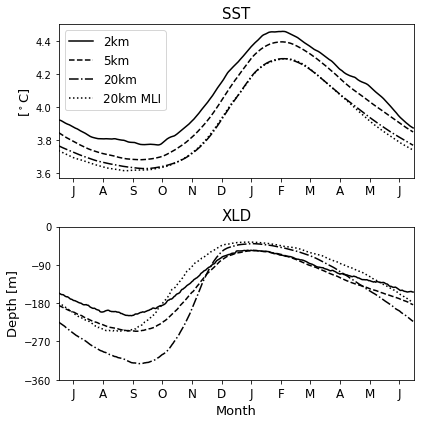

In [43]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
fig.set_tight_layout(True)
ax1.plot(range(360), Tday, 'k', label='2km')
ax1.plot(range(360), SSTb05[:,0].roll(days=-180), 'k--', label='5km')
ax1.plot(range(360), SSTb20[:,0].roll(days=-180), 'k-.', label='20km')
ax1.plot(range(360), SSTb20mli[:,0].roll(days=-180), 'k:', label='20km MLI')

ax2.plot(range(360), -XLD02day.sel(YC=slice(6e5,14e5)).mean('YC').roll(day=-180), color='k', ls='-', label=r'2 km')
ax2.plot(range(360), -XLD05day.sel(YC=slice(6e5,14e5)).mean('YC').roll(day=-180), color='k', ls='--', label=r'5 km')
ax2.plot(range(360), -XLD20day.sel(YC=slice(6e5,14e5)).mean('YC').roll(day=-180), color='k', ls='-.', label=r'20 km')
ax2.plot(range(360), -XLD20mliday.sel(YC=slice(6e5,14e5)).mean('YC').roll(day=-180), color='k', ls=':', label=r'20 km MLI')

ax1.set_xticks(range(15,360,30))
ax1.set_xticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],-6), fontsize=12)
ax2.set_xticks(range(15,360,30))
ax2.set_xticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],-6), fontsize=12)
ax2.set_xlabel(r"Month", fontsize=13)
ax1.set_ylabel(r"[$^\circ$C]", fontsize=13)
ax2.set_ylabel(r"Depth [m]", fontsize=13)
ax1.set_title(r"SST", fontsize=15)
ax2.set_title(r"XLD", fontsize=15)
ax1.legend(loc='upper left', fontsize=12)
ax1.set_xlim([0.,360.])
ax2.set_xlim([0.,360.])
ax2.set_ylim([-3.6e2,0.])
ax2.set_yticks([-360,-270,-180,-90,0])
# ax2.set_yticklabels(np.array([-360,-270,-180,-90,0]))
plt.savefig(op.join(ddir,'../Figures/SST_XLD_res-comp.pdf'))

KeyboardInterrupt: 

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


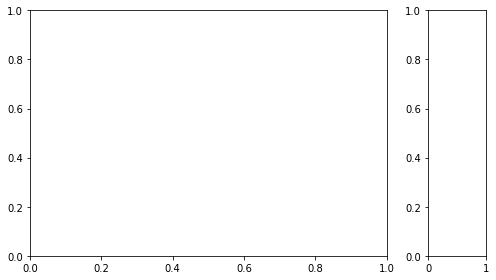

In [8]:
from matplotlib.gridspec import GridSpec as GS

fig = plt.figure(figsize=(7,4))
fig.set_tight_layout(True)
gs = GS(nrows=1,ncols=5)
ax1 = fig.add_subplot(gs[0,:-1])
ax2 = fig.add_subplot(gs[0,-1])
im = ax1.pcolormesh(dsday.YC*1e-3, np.arange(0,360), dsday.THETA[:,0].roll(time=-0).mean('XC'),
                   cmap='Reds', vmin=1, vmax=7, extend='both')
ax2.plot(dsday.THETA[:,0].sel(YC=slice(6e5,14e5)).roll(time=-0).mean(['YC','XC']), np.arange(.5,12.5), 'k.-', lw=2)
ax1.set_yticks(np.linspace(.5,359.5,12))
ax1.set_yticklabels(np.roll(np.asarray(['J','F','M','A','M','J','J','A','S','O','N','D']),-6), fontsize=12)
ax2.set_yticks(np.linspace(.5,359.5,12))
ax2.set_yticklabels(np.roll(np.asarray(['J','F','M','A','M','J','J','A','S','O','N','D']),-6), fontsize=12)
ax1.set_xlabel(r"Y [km]", fontsize=14)
ax1.set_ylabel(r"Month", fontsize=14)
ax2.set_xlabel(r"[$^\circ$C]", fontsize=14)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label(r"[$^\circ$C]", fontsize=12)
# plt.savefig(op.join(ddir,'../Figures/SST_02km.pdf'))

In [358]:
dsday.PHIHYD.attrs

OrderedDict([('standard_name', 'PHIHYD'),
             ('long_name', 'Hydrostatic Pressure Pot.(p/rho) Anomaly'),
             ('units', 'm^2/s^2')])

In [19]:
# ds1H = open_mdsdataset(op.join(ddir,'02km_snap1H'), grid_dir=op.join(ddir,'02km_grid'),
#                        iters=range(int(ts+360*86400/dt),te,36), prefix=['Snap1H'], delta_t=dt
#                        )
# ds1H

In [12]:
# with ProgressBar():
#     w1Df = xrft.power_spectrum(dsday.WVEL.sel(YC=slice(6e5,14e5))[180:270].chunk({'time':90,'YC':100,'XC':100})[:,33], 
#                                dim=['time'], window=True, detrend='linear', density=False).compute()
#     w1Hf = xrft.power_spectrum(ds1H.WVEL.sel(YC=slice(6e5,14e5))[4320:6480].chunk({'time':2160,'YC':100,'XC':100})[:,33], 
#                                dim=['time'], window=True, detrend='linear', density=False).compute()
# w1Hf

In [13]:
# fig, ax = plt.subplots()
# ax.plot(w1Df.freq_time[46:]*86400, w1Df[46:].mean(['YC','XC'])*w1Df.freq_time[46:], 'k')
# ax.plot(w1Hf.freq_time[1081:]*86400, w1Hf[1081:].mean(['YC','XC'])*w1Hf.freq_time[1081:], 'r')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel(r"[cpd]", fontsize=13)
# ax.set_ylabel(r"$\omega$w$^2$", fontsize=13)

In [21]:
# dsday.coords['seas'] = ('time',np.tile(np.repeat(np.roll(range(4),-2),90),dy))
# phisea = dsday.PHIHYD.groupby('seas').mean(['time','XC'])
dsmon.coords['seas'] = ('time',np.tile(np.repeat(np.roll(range(4),0),3),dy))
dmsea = dsmon.groupby('seas').mean(['time','XC','XG'])
dmsea

<xarray.Dataset>
Dimensions:   (YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, seas: 4)
Coordinates:
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Z         (Z) >f4 -0.5 -1.57 -2.79 -4.185 ... -2625.955 -2757.325 -2912.665
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.14 -3.44 ... -2689.32 -2825.33 -3000.0
  * Zu        (Zu) >f4 -1.0 -2.14 -3.44 -4.93 ... -2689.32 -2825.33 -3000.0
  * Zl        (Zl) >f4 0.0 -1.0 -2.14 -3.44 ... -2562.59 -2689.32 -2825.33
    drC       (Zp1) >f4 0.5 1.07 1.22 1.395 ... 122.54 131.37 155.34 87.335
    drF       (Z) >f4 1.0 1.14 1.3 1.49 1.7 ... 118.35 126.73 136.01 174.67
    PHrefC    (Z) >f4 4.905 15.4017 27.3699 ... 25760.62 27049.357 28573.244
    PHrefF    (Zp1) >f4 0.0 9.81 20.9934 33.7464 ... 26382.229 27716.486 29430.0
  * seas      (seas) int64 0 1 2 3
Data variables:
    uVeltave  (seas, Z, YC) float32 dask.array<shape=(4, 76, 400), chunksi

In [15]:
with ProgressBar():
    udp = (dsday.UVEL.groupby('seas') - dmsea.uVeltave).load()
udp

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

<xarray.DataArray (time: 360, Z: 76, YC: 1000, XG: 500)>
array([[[[ 0.      , ...,  0.      ],
         ...,
         [-0.020934, ..., -0.017132]],

        ...,

        [[ 0.      , ...,  0.      ],
         ...,
         [-0.005867, ..., -0.005783]]],


       ...,


       [[[ 0.      , ...,  0.      ],
         ...,
         [ 0.021673, ...,  0.015723]],

        ...,

        [[ 0.      , ...,  0.      ],
         ...,
         [-0.014299, ..., -0.014057]]]], dtype=float32)
Coordinates:
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XG       (XG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
    dyG      (YC, XG) >f4 2000.0 2000.0 2000.0 2000.0 2000.0 2000.0 2000.0 ...
    dxC      (YC, XG) >f4 2000.0 2000.0 2000.0 2000.0 2000.0 2000.0 2000.0 ...
    rAw      (YC, XG) >f4 4000000.0 4000000.0 4000000.0 4000000.0 4000000.0 ...
    drF      (Z) >f4 1.0 1.14 1.3 1.49

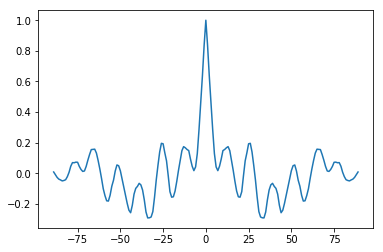

In [19]:
auto = np.correlate(udp.data[:90,0,500,250], udp.data[:90,0,500,250], mode='full')
plt.plot(range(-89,90), auto/auto.max())

In [23]:
auto[89:]/auto.max()

array([ 1.        ,  0.8364192 ,  0.63705415,  0.45904708,  0.28463492,
        0.12837015,  0.04096499,  0.01646432,  0.04559906,  0.09255408,
        0.14756939,  0.15482923,  0.16584024,  0.17345786,  0.14713457,
        0.08320603,  0.01857072, -0.05318738, -0.11687195, -0.15455912,
       -0.15704218, -0.12100499, -0.01691082,  0.08026134,  0.13319288,
        0.19206874,  0.19510575,  0.1385589 ,  0.05165676, -0.04380018,
       -0.15607595, -0.2513412 , -0.2865982 , -0.29189572, -0.29265368,
       -0.25418037, -0.17455715, -0.11044256, -0.07663357, -0.06650507,
       -0.08635489, -0.09945337, -0.13708094, -0.20972246, -0.25868002,
       -0.2420851 , -0.19716264, -0.14290284, -0.09151033, -0.03796722,
        0.01576622,  0.04856835,  0.0536067 ,  0.01380033, -0.04586237,
       -0.08535182, -0.14457181, -0.18248907, -0.18062213, -0.14694266,
       -0.10180093, -0.03478453,  0.02731621,  0.0825817 ,  0.13137086,
        0.15688978,  0.15576725,  0.15412173,  0.12204891,  0.08

In [38]:
with ProgressBar():
    N2_seas = alpha*g * (grid.diff(dmsea.Ttave,'Z',boundary='fill')
                        / grid.diff(dmsea.Z,'Z',boundary='fill')
                        ).compute()
N2_seas

[########################################] | 100% Completed |  0.3s


<xarray.DataArray (seas: 4, Zl: 76, YC: 400)>
array([[[-0.000000e+00, -3.035152e-03, ..., -3.114551e-02, -3.121993e-02],
        [-0.000000e+00, -2.211231e-06, ...,  3.542883e-04,  3.405182e-04],
        ...,
        [-0.000000e+00,  1.330836e-10, ...,  2.690565e-06,  2.686507e-06],
        [-0.000000e+00,  2.710180e-11, ...,  2.435435e-07,  2.112103e-07]],

       [[-0.000000e+00, -3.001975e-03, ..., -3.098927e-02, -3.113634e-02],
        [-0.000000e+00, -2.232434e-06, ...,  3.839105e-04,  3.786040e-04],
        ...,
        [-0.000000e+00,  7.700154e-11, ...,  2.730725e-06,  2.724960e-06],
        [-0.000000e+00,  2.559614e-11, ...,  2.528876e-07,  2.249167e-07]],

       [[-0.000000e+00, -2.918103e-03, ..., -3.089384e-02, -3.106573e-02],
        [-0.000000e+00, -2.251998e-06, ...,  4.803416e-04,  4.855449e-04],
        ...,
        [-0.000000e+00,  5.296638e-11, ...,  2.789730e-06,  2.787297e-06],
        [-0.000000e+00,  2.710180e-11, ...,  2.657064e-07,  2.380166e-07]],

       [[

In [19]:
dsmom.coords['seas'] = ('time',np.append(np.tile(np.repeat(np.roll(range(4),0),6),dy),1))
dsmom.coords['day'] = ('time',np.tile(np.roll(range(25),0),dy))
grid = Grid(dsmom, periodic=['X'])

In [22]:
up = (dsmom.U.groupby('seas') - dmsea.uVeltave)
vp = (dsmom.V.groupby('seas') - dmsea.vVeltave)
wp = (dsmom.W.groupby('seas') - dmsea.wVeltave)
# phip = dsmom.PH.groupby('seas') - phisea
phip = dsmom.PH.groupby('seas') - dmsea.PhHytave

bp = grid.diff(phip,'Z',boundary='fill')/grid.diff(phip.Z,'Z',boundary='fill')
print(wp,bp)

<xarray.DataArray (time: 25, Zl: 76, YC: 400, XC: 200)>
dask.array<shape=(25, 76, 400, 200), dtype=float32, chunksize=(1, 76, 400, 200)>
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 ... 987500.0 992500.0 997500.0
  * YC       (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 ... -2562.59 -2689.32 -2825.33
    rA       (YC, XC) >f4 25000000.0 25000000.0 ... 25000000.0 25000000.0
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 ... 2985.0 2985.0 2985.0 2985.0
    iter     (time) int64 dask.array<shape=(25,), chunksize=(1,)>
  * time     (time) int64 4105728000 4107024000 ... 4135536000 4136832000
    seas     (time) int64 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 1
    day      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24 <xarray.DataArray (time: 25, Zl: 76, YC: 400, XC: 200)>
dask.array<shape=(25, 76, 400, 200), dtype=float32, chunksize=(1, 1, 400, 200)>
Coordinates:
  * time     (time) int64 

In [147]:
bp.to_dataset(name='bp').to_netcdf(op.join(ddir,'BuoyancyPrime_05km.nc'))

In [11]:
with ProgressBar():
    wpbp = (wp*bp).compute()
wpbp

[########################################] | 100% Completed | 25.6s


<xarray.DataArray (time: 25, Zl: 76, YC: 1000, XC: 500)>
array([[[[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [ 4.890315e-09, ...,  3.965386e-09]],

        ...,

        [[-0.000000e+00, ..., -0.000000e+00],
         ...,
         [ 7.668745e-11, ..., -1.260959e-10]]],


       ...,


       [[[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [-3.513423e-08, ..., -3.650552e-08]],

        ...,

        [[-0.000000e+00, ..., -0.000000e+00],
         ...,
         [-3.180674e-11, ..., -1.268560e-10]]]], dtype=float32)
Coordinates:
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 4000000.0 4000000.0 4000000.0 4000000.0 4000000.0 ...
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    iter     (time) int64 3499200 3531600 35640

In [12]:
wpbp.coords['day'] = ('time',np.tile(np.roll(range(25),-12),dy))
wpbp.to_dataset(name='wpbp').to_netcdf(op.join(ddir,'APEconversion_02km.nc'))
# wpbp = xr.open_dataset(op.join(ddir,'APEconversion_02km.nc')).wpbp
with ProgressBar():
    wpbpd = wpbp.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
    wpbp_seas = wpbp.groupby('seas').mean(['time','XC']).compute()

In [13]:
# dsmom.coords['day'] = ('time',np.tile(np.roll(range(24),-12),dy))
wp.coords['day'] = ('time',np.tile(np.roll(range(25),-12),dy))
with ProgressBar():
#     w2 = ((dsnap.WVEL.sel(YC=slice(6e5,14e5))*86400)**2).groupby('day').mean(['time','YC','XC']).compute()
    w2 = ((wp.sel(YC=slice(6e5,14e5))*86400)**2).groupby('day').mean(['time','YC','XC']).compute()
w2sqrt = np.sqrt(w2)
w2sqrt

[########################################] | 100% Completed | 13.4s


<xarray.DataArray (day: 25, Zl: 76)>
array([[ 0.048667,  0.295551,  0.625978, ...,  6.830006,  9.003355, 12.571099],
       [ 0.052113,  0.30669 ,  0.647591, ...,  6.771914,  8.95811 , 12.787103],
       [ 0.049436,  0.326587,  0.691999, ...,  5.975603,  7.877721, 11.695501],
       ...,
       [ 0.057738,  0.416309,  0.883696, ...,  6.723765,  8.853948, 12.926385],
       [ 0.060154,  0.352105,  0.745802, ...,  7.167846,  9.608415, 14.368504],
       [ 0.05024 ,  0.319514,  0.677915, ...,  6.630043,  8.97249 , 13.47152 ]])
Coordinates:
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

# Frontogenesis function and strain
### $$\alpha = \Big[\big(u_x-v_y\big)^2 + \big(v_x+u_y\big)^2\Big]^{1/2}$$
### $$F_s = \boldsymbol{Q}_s \cdot \nabla_z b$$
where $\boldsymbol{Q}_s = -(u_xb_x + v_xb_y + w_xb_z, u_yb_x + v_yb_y + w_yb_z)$.

In [7]:
grid = Grid(dsmom, periodic=['X'])
u = dsmom.U
v = dsmom.V
w = dsmom.W
phi = dsmom.PH
b = (grid.diff(phi,'Z',boundary='fill')/grid.diff(phi.Z,'Z',boundary='fill'))
uk = xrft.dft(u, dim=['XG'], shift=False)
vk = xrft.dft(v, dim=['XC'], shift=False)
wk = xrft.dft(w, dim=['XC'], shift=False)
bk = xrft.dft(b, dim=['XC'], shift=False)
ux = xr.DataArray(fft.ifft((2j*np.pi*uk*uk.freq_XG).data, axis=-1).real, 
                 dims=u.dims, coords=u.coords).compute()
vx = xr.DataArray(fft.ifft((2j*np.pi*vk*vk.freq_XC).data, axis=-1).real, 
                 dims=v.dims, coords=v.coords).compute()
wx = xr.DataArray(fft.ifft((2j*np.pi*wk*wk.freq_XC).data, axis=-1).real, 
                 dims=w.dims, coords=w.coords).compute()
bx = xr.DataArray(fft.ifft((2j*np.pi*bk*bk.freq_XC).data, axis=-1).real, 
                 dims=b.dims, coords=b.coords)
uy = grid.diff(u*dsmom.dxC,'Y',boundary='fill') / dsmom.rAz
vy = grid.diff(v*dsmom.dxG,'Y',boundary='fill') / dsmom.rA
wy = grid.diff(w*grid.interp(dsmom.dxG,'Y',boundary='fill'), 'Y', boundary='fill')/dsmom.rAs
by = grid.diff(b*grid.interp(dsmom.dxG,'Y',boundary='fill'), 'Y', boundary='fill')/dsmom.rAs
print(uy.coords, vy.coords, wy.coords, by.coords)

Coordinates:
  * time     (time) int64 4105728000 4107024000 ... 4135536000 4136832000
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 ... -2625.955 -2757.325 -2912.665
  * YG       (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 ... 985000.0 990000.0 995000.0
    rAz      (YG, XG) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)> Coordinates:
  * time     (time) int64 4105728000 4107024000 ... 4135536000 4136832000
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 ... -2625.955 -2757.325 -2912.665
  * YC       (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XC       (XC) >f4 2500.0 7500.0 12500.0 ... 987500.0 992500.0 997500.0
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)> Coordinates:
  * time     (time) int64 4105728000 4107024000 ... 4135536000 4136832000
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44

In [86]:
# wk = xr.DataArray(wk.data, dims=wk.dims, 
#                   coords={'time':w.time.data,'Zl':w.Zl.data,'YC':w.YC.data,
#                          'freq_XC':wk.freq_XC.data}
#                  )
# bk = xr.DataArray(bk.data, dims=bk.dims, 
#                   coords={'time':b.time.data,'Zl':b.Zl.data,'YC':b.YC.data,
#                          'freq_XC':bk.freq_XC.data}
#                  )

In [8]:
advx = grid.interp(u*ux,'X') + grid.interp(v*grid.interp(uy,'X'),'Y',boundary='fill')
advx

<xarray.DataArray (time: 25, Z: 76, YC: 400, XC: 200)>
dask.array<shape=(25, 76, 400, 200), dtype=float64, chunksize=(1, 76, 1, 199)>
Coordinates:
  * time     (time) int64 4105728000 4107024000 ... 4135536000 4136832000
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 ... -2625.955 -2757.325 -2912.665
  * YC       (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XC       (XC) >f4 2500.0 7500.0 12500.0 ... 987500.0 992500.0 997500.0

In [9]:
advy = grid.interp(u,'X')*grid.interp(vx,'Y',boundary='fill') + grid.interp(v,'Y',boundary='fill')*vy
advy

<xarray.DataArray (time: 25, Z: 76, YC: 400, XC: 200)>
dask.array<shape=(25, 76, 400, 200), dtype=float64, chunksize=(1, 76, 399, 199)>
Coordinates:
  * time     (time) int64 4105728000 4107024000 ... 4135536000 4136832000
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 ... -2625.955 -2757.325 -2912.665
  * YC       (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XC       (XC) >f4 2500.0 7500.0 12500.0 ... 987500.0 992500.0 997500.0
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>

In [15]:
advxk = xrft.cross_spectrum(grid.interp(u,'X').chunk({'XC':200}).sel(YC=slice(6e5,14e5)),
                           advx.chunk({'XC':200}).sel(YC=slice(6e5,14e5)), 
                           dim=['XC'], density=False, detrend='constant')
advyk = xrft.cross_spectrum(grid.interp(v,'Y',boundary='fill').chunk({'XC':200}).sel(YC=slice(6e5,14e5)),
                           advy.chunk({'XC':200}).sel(YC=slice(6e5,14e5)), 
                           dim=['XC'], density=False, detrend='constant')
with ProgressBar():
    advk = (advxk+advyk).compute()
advk

[########################################] | 100% Completed |  6.8s


<xarray.DataArray (time: 25, Z: 76, YC: 160, freq_XC: 200)>
array([[[[-3.624543e-08, ..., -1.414785e-08],
         ...,
         [ 2.945886e-10, ...,  3.304349e-09]],

        ...,

        [[ 1.324440e-13, ...,  1.955306e-14],
         ...,
         [-4.028458e-13, ..., -1.027736e-12]]],


       ...,


       [[[-1.269694e-08, ..., -1.117501e-08],
         ...,
         [ 4.671468e-08, ..., -6.605379e-08]],

        ...,

        [[ 3.613329e-14, ...,  1.461890e-12],
         ...,
         [-3.123632e-12, ...,  6.330671e-13]]]])
Coordinates:
  * time             (time) int64 4105728000 4107024000 ... 4136832000
  * Z                (Z) >f4 -0.5 -1.57 -2.79 ... -2625.955 -2757.325 -2912.665
  * YC               (YC) >f4 602500.0 607500.0 612500.0 ... 1392500.0 1397500.0
  * freq_XC          (freq_XC) float64 -0.0001 -9.9e-05 ... 9.8e-05 9.9e-05
    freq_XC_spacing  float64 1e-06

In [71]:
# advk = xr.DataArray(advk.data, dims=['time','Z','YC','freq_XC'],
#                    coords={'time':advx.time.data, 'Z':advx.Z.data, 'YC':advx.sel(YC=slice(6e5,14e5)).YC.data,
#                           'freq_XC':advxk.freq_XC.data})

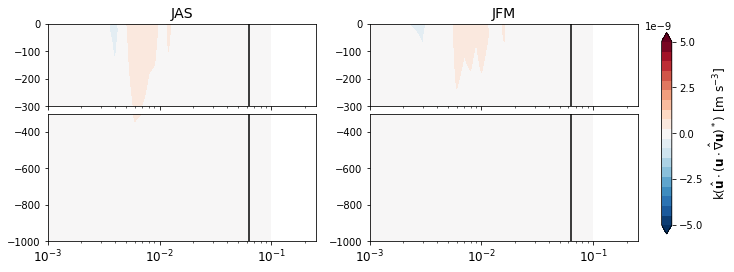

In [41]:
fig = plt.figure(figsize=(11,4))
gs = GS(5, 2)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0])
ax3 = fig.add_subplot(gs[:2,1])
ax4 = fig.add_subplot(gs[2:,1])
# fig.set_tight_layout(True)
im1 = ax1.contourf(advk.freq_XC[100:]*1e3, advk.Z, 
                  (advk[:,:,:,100:][:6].mean(['time','YC'])*advk.freq_XC),
                  cmap='RdBu_r', levels=1e-8*np.linspace(-.5,.5,20), extend='both')
ax2.contourf(advk.freq_XC[100:]*1e3, advk.Z, 
            (advk[:,:,:,100:][:6].mean(['time','YC'])*advk.freq_XC),
            cmap='RdBu_r', levels=1e-8*np.linspace(-.5,.5,20), extend='both')
ax1.plot(np.ones(5)*Rd**-1, np.linspace(-3e2,0,5), 'k')
ax2.plot(np.ones(5)*Rd**-1, np.linspace(-10e2,-3e2,5), 'k')
# im2 = ax2.contourf(wk.sel(freq_XC=slice(1e-6,wk.freq_XC.max())).freq_XC*1e3, wk.Zl, 
#                   (wkbkOND*wk.freq_XC).sel(freq_XC=slice(1e-6,wk.freq_XC.max())),
#                   cmap='RdBu_r', levels=1e-9*np.linspace(-1.2,1.2,20), extend='both')
im3 = ax3.contourf(advk.freq_XC[100:]*1e3, advk.Z, 
                  (advk[:,:,:,100:][12:18].mean(['time','YC'])*advk.freq_XC),
                  cmap='RdBu_r', levels=1e-8*np.linspace(-.5,.5,20), extend='both')
ax4.contourf(advk.freq_XC[100:]*1e3, advk.Z, 
            (advk[:,:,:,100:][12:18].mean(['time','YC'])*advk.freq_XC),
            cmap='RdBu_r', levels=1e-8*np.linspace(-.5,.5,20), extend='both')
ax3.plot(np.ones(5)*Rd**-1, np.linspace(-3e2,0,5), 'k')
ax4.plot(np.ones(5)*Rd**-1, np.linspace(-10e2,-3e2,5), 'k')
ax1.set_xscale('log')
ax1.set_xlim([1e-3,2.5e-1])
ax1.set_xticks([1e-3,1e-2,1e-1])
ax1.set_xticklabels([])
# ax1.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax2.set_xscale('log')
ax2.set_xlim([1e-3,2.5e-1])
ax2.set_xticks([1e-3,1e-2,1e-1])
ax2.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
ax2.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax1.set_ylim([-3e2,0])
ax2.set_ylim([-10e2,-3e2])
# ax2.set_xscale('log')
# ax2.set_xlim([1e-3,2.5e-1])
# ax2.set_xticks([1e-3,1e-2,1e-1])
# ax2.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
# ax2.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax3.set_xscale('log')
ax3.set_xlim([1e-3,2.5e-1])
ax3.set_xticks([1e-3,1e-2,1e-1])
ax3.set_xticklabels([])
# ax3.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax4.set_xscale('log')
ax4.set_xlim([1e-3,2.5e-1])
ax4.set_xticks([1e-3,1e-2,1e-1])
ax4.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
ax4.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax3.set_ylim([-3e2,0])
ax4.set_ylim([-10e2,-3e2])
ax1.set_title(r"JAS", fontsize=14)
# ax2.set_title(r"OND", fontsize=14)
ax3.set_title(r"JFM", fontsize=14)
# ax1.set_ylim([-1000,0])
# ax2.set_ylim([-1000,0])
# ax3.set_ylim([-1000,0])
# ax2.set_xlabel(r"k [cpkm]", fontsize=13)
# ax1.set_ylabel(r"Depth [m]", fontsize=13)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.013, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax, ticks=1e-8*np.array([-.5,-.25,0,.25,.5]))
cbar.set_label(r"k$(\hat{\bf u}\cdot \hat{({\bf u}\cdot\nabla{\bf u})}^*)$ [m s$^{-3}$]", fontsize=12)
# plt.savefig(op.join(ddir,'../Figures/energytrans_seas_02km.pdf'))

In [16]:
with ProgressBar():
    KEfluxJFM = -advk[:6,:,:,100:][:,:,:,::-1].cumsum(dim='freq_XC')[:,:,:,::-1].compute()
    KEfluxJAS = -advk[12:18,:,:,100:][:,:,:,::-1].cumsum(dim='freq_XC')[:,:,:,::-1].compute()
#     KEfluxJAS = -advk[:6,:,:,250:].cumsum(dim='freq_XC').compute()
#     KEfluxJFM = -advk[12:18,:,:,250:].cumsum(dim='freq_XC').compute()
KEfluxJAS

<xarray.DataArray (time: 6, Z: 76, YC: 160, freq_XC: 100)>
array([[[[-1.619892e-03, ..., -1.332441e-08],
         ...,
         [ 7.614388e-04, ..., -9.521697e-11]],

        ...,

        [[-9.801576e-06, ...,  1.946109e-12],
         ...,
         [-4.197700e-06, ...,  1.050583e-13]]],


       ...,


       [[[-1.722883e-03, ...,  1.116975e-07],
         ...,
         [ 9.182521e-04, ...,  3.299566e-08]],

        ...,

        [[ 1.624102e-05, ...,  3.160224e-12],
         ...,
         [ 3.539429e-05, ..., -1.158288e-12]]]])
Coordinates:
  * time             (time) int64 4121280000 4122576000 ... 4127760000
  * Z                (Z) >f4 -0.5 -1.57 -2.79 ... -2625.955 -2757.325 -2912.665
  * YC               (YC) >f4 602500.0 607500.0 612500.0 ... 1392500.0 1397500.0
  * freq_XC          (freq_XC) float64 0.0 1e-06 2e-06 ... 9.8e-05 9.9e-05
    freq_XC_spacing  float64 1e-06

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


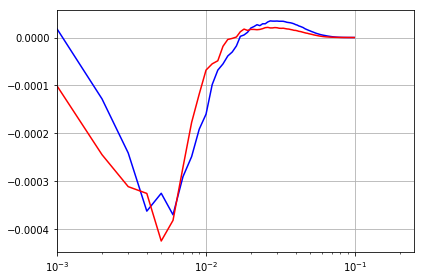

In [52]:
fig = plt.figure()
fig.set_tight_layout(True)
gs = GS(1,3)
ax1 = fig.add_subplot(gs[0,:3])
# ax2 = fig.add_subplot(gs[0,2])
ax1.plot(KEfluxJAS.freq_XC[1:]*1e3, (KEfluxJAS.mean(['time','YC']))[0,1:], 'b')
ax1.plot(KEfluxJFM.freq_XC[1:]*1e3, (KEfluxJFM.mean(['time','YC']))[0,1:], 'r')
# ax2.plot(KEfluxJAS.freq_XC[1:]*1e3, (KEfluxJAS.mean(['time','YC']))[0,1:], 'b')
# ax2.plot(KEfluxJFM.freq_XC[1:]*1e3, (KEfluxJFM.mean(['time','YC']))[0,1:], 'r')
ax1.set_xscale('log')
# ax2.set_xscale('log')
# ax2.set_ylim([-2e-9,2e-9])
ax1.set_xlim([1e-3,.25])
# ax2.set_xlim([.24,.25])
ax1.grid(True)
# ax2.grid(True)

In [53]:
KEfluxJAS.mean(['time','YC'])[:,-10:]

<xarray.DataArray (Z: 76, freq_XC: 10)>
array([[2.152366e-07, 2.012117e-07, 1.875440e-07, ..., 1.069664e-07,
        8.052013e-08, 4.258728e-08],
       [2.134604e-07, 1.994819e-07, 1.859573e-07, ..., 1.061004e-07,
        7.977003e-08, 4.217720e-08],
       [2.110695e-07, 1.971747e-07, 1.838529e-07, ..., 1.050098e-07,
        7.886038e-08, 4.168737e-08],
       ...,
       [9.993972e-11, 9.407052e-11, 9.182689e-11, ..., 6.352739e-11,
        5.191894e-11, 3.015075e-11],
       [2.968687e-10, 2.771636e-10, 2.527277e-10, ..., 1.323080e-10,
        1.075458e-10, 5.640517e-11],
       [6.172261e-10, 5.807877e-10, 5.381635e-10, ..., 2.652826e-10,
        2.118954e-10, 1.106761e-10]])
Coordinates:
  * freq_XC          (freq_XC) float64 0.00024 0.000241 ... 0.000248 0.000249
    freq_XC_spacing  float64 1e-06
Dimensions without coordinates: Z

In [17]:
# Rd = 13.68163052
Rd = (1.01390163e-05*2*np.pi)**-1*1e-3
Rd

15.697276578191847

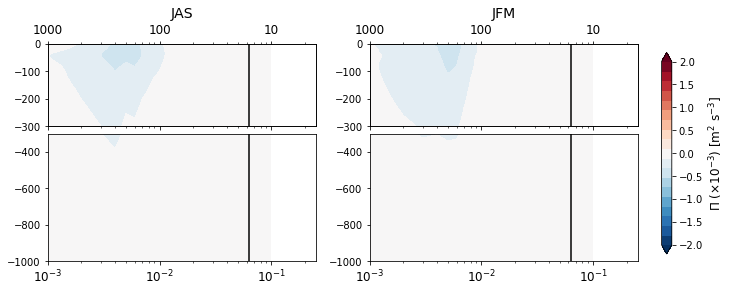

In [18]:
fig = plt.figure(figsize=(11,4))
gs = GS(5, 2)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0])
ax3 = fig.add_subplot(gs[:2,1])
ax4 = fig.add_subplot(gs[2:,1])
ax5 = ax1.twiny()
ax6 = ax3.twiny()
# fig.set_tight_layout(True)
im1 = ax1.contourf(KEfluxJAS.freq_XC*1e3, KEfluxJAS.Z, 
                  (KEfluxJAS.mean(['time','YC']))*1e3,
                  cmap='RdBu_r', levels=1e0*np.linspace(-2,2,20), extend='both')
im2 = ax2.contourf(KEfluxJAS.freq_XC*1e3, KEfluxJAS.Z, 
                (KEfluxJAS.mean(['time','YC']))*1e3,
                cmap='RdBu_r', levels=1e0*np.linspace(-2,2,20), extend='both')
ax1.plot(np.ones(5)*Rd**-1, np.linspace(-3e2,0,5), 'k')
ax2.plot(np.ones(5)*Rd**-1, np.linspace(-10e2,-3e2,5), 'k')
# im2 = ax2.contourf(wk.sel(freq_XC=slice(1e-6,wk.freq_XC.max())).freq_XC*1e3, wk.Zl, 
#                   (wkbkOND*wk.freq_XC).sel(freq_XC=slice(1e-6,wk.freq_XC.max())),
#                   cmap='RdBu_r', levels=1e-9*np.linspace(-1.2,1.2,20), extend='both')
im3 = ax3.contourf(KEfluxJFM.freq_XC*1e3, KEfluxJFM.Z, 
                  (KEfluxJFM.mean(['time','YC']))*1e3,
                  cmap='RdBu_r', levels=1e0*np.linspace(-2,2,20), extend='both')
im4 = ax4.contourf(KEfluxJFM.freq_XC*1e3, KEfluxJFM.Z, 
                (KEfluxJFM.mean(['time','YC']))*1e3,
                cmap='RdBu_r', levels=1e0*np.linspace(-2,2,20), extend='both')

for c in im1.collections:
    c.set_rasterized(True)
for c in im2.collections:
    c.set_rasterized(True)
for c in im3.collections:
    c.set_rasterized(True)
for c in im4.collections:
    c.set_rasterized(True)
    
ax3.plot(np.ones(5)*Rd**-1, np.linspace(-3e2,0,5), 'k')
ax4.plot(np.ones(5)*Rd**-1, np.linspace(-10e2,-3e2,5), 'k')
ax1.set_xscale('log')
ax1.set_xlim([1e-3,2.5e-1])
ax1.set_xticks([1e-3,1e-2,1e-1])
ax1.set_xticklabels([])
# ax1.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax2.set_xscale('log')
ax2.set_xlim([1e-3,2.5e-1])
ax2.set_xticks([1e-3,1e-2,1e-1])
ax2.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
ax2.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax1.set_ylim([-3e2,0])
ax2.set_ylim([-10e2,-3e2])

ax5.set_xscale('log')
ax5.set_xlim([1e-3,2.5e-1])
ax5.set_xticks([1e-3,1e-2,1e-1])
ax5.set_xticklabels(np.asarray([1e3,1e2,1e1],dtype=int), fontsize=12)
ax6.set_xscale('log')
ax6.set_xlim([1e-3,2.5e-1])
ax6.set_xticks([1e-3,1e-2,1e-1])
ax6.set_xticklabels(np.asarray([1e3,1e2,1e1],dtype=int), fontsize=12)
# ax2.set_xscale('log')
# ax2.set_xlim([1e-3,2.5e-1])
# ax2.set_xticks([1e-3,1e-2,1e-1])
# ax2.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
# ax2.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax3.set_xscale('log')
ax3.set_xlim([1e-3,2.5e-1])
ax3.set_xticks([1e-3,1e-2,1e-1])
ax3.set_xticklabels([])
# ax3.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax4.set_xscale('log')
ax4.set_xlim([1e-3,2.5e-1])
ax4.set_xticks([1e-3,1e-2,1e-1])
ax4.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
ax4.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax3.set_ylim([-3e2,0])
ax4.set_ylim([-10e2,-3e2])
ax1.set_title(r"JAS", fontsize=14)
# ax2.set_title(r"OND", fontsize=14)
ax3.set_title(r"JFM", fontsize=14)
# ax1.set_ylim([-1000,0])
# ax2.set_ylim([-1000,0])
# ax3.set_ylim([-1000,0])
# ax2.set_xlabel(r"k [cpkm]", fontsize=13)
# ax1.set_ylabel(r"Depth [m]", fontsize=13)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.013, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax, ticks=1e0*np.array([-2,-1.5,-1.,-.5,0,.5,1.,1.5,2]))
cbar.set_label(r"$\Pi\ (\times 10^{-3})$ [m$^2$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(takadir,'Figures/energyflux_seas_05km.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


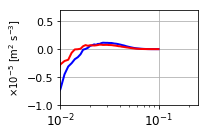

In [54]:
fig, ax1 = plt.subplots(figsize=(3,2))
fig.set_tight_layout(True)
# gs = GS(1,3)
# ax1 = fig.add_subplot(gs[0,:3])
# ax2 = fig.add_subplot(gs[0,2])
ax1.plot(KEfluxJAS.freq_XC[1:]*1e3, (KEfluxJAS[:,:22]*dsmom.drF).mean(['time','Z','YC'])[1:]*1e3, 'b', lw=2)
ax1.plot(KEfluxJFM.freq_XC[1:]*1e3, (KEfluxJFM[:,:22]*dsmom.drF).mean(['time','Z','YC'])[1:]*1e3, 'r', lw=2)
# ax2.plot(KEfluxJAS.freq_XC[1:]*1e3, (KEfluxJAS.mean(['time','YC']))[0,1:], 'b')
# ax2.plot(KEfluxJFM.freq_XC[1:]*1e3, (KEfluxJFM.mean(['time','YC']))[0,1:], 'r')
ax1.set_xscale('log')
# ax2.set_xscale('log')
# ax2.set_ylim([-2e-9,2e-9])
ax1.set_xlim([1e-2,.25])
ax1.set_ylim([-1e0,7e-1])
# ax1.set_xticks([3e-2,6e-2,.1,.2])
# ax1.set_xticklabels([3e-2,6e-2,.1,.2], fontsize=12)
# ax2.set_xlim([.24,.25])
ax1.set_ylabel(r"$\times 10^{-5}$ [m$^2$ s$^{-3}$]")
ax1.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
# ax2.grid(True)
plt.savefig(op.join(takadir,'Figures/energyflux_seas_05km-top100m.pdf'))

In [15]:
with ProgressBar():
    ampgradb = np.sqrt(bx**2 + grid.interp(by,'Y',boundary='fill')**2
                      ).compute()
ampgradb

[########################################] | 100% Completed | 53.2s


<xarray.DataArray (time: 25, Zl: 76, YC: 1000, XC: 500)>
array([[[[8.941331e-03, ..., 8.941216e-03],
         ...,
         [4.472759e-03, ..., 4.472523e-03]],

        ...,

        [[1.006115e-05, ..., 1.006119e-05],
         ...,
         [4.946217e-06, ..., 4.946089e-06]]],


       ...,


       [[[9.090482e-03, ..., 9.090339e-03],
         ...,
         [4.445695e-03, ..., 4.446510e-03]],

        ...,

        [[1.005957e-05, ..., 1.005970e-05],
         ...,
         [4.955863e-06, ..., 4.955941e-06]]]])
Coordinates:
  * time     (time) float64 1.4e+08 1.413e+08 1.426e+08 1.439e+08 1.452e+08 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...

In [16]:
zeta = grid.interp(vx,'X')-uy
alf = np.sqrt((grid.interp(ux,'X') - vy)**2 
             + (grid.interp(vx,'Y',boundary='fill') + grid.interp(grid.interp(uy,'X'),
                                                                 'Y',boundary='fill'))**2
             )
alf

<xarray.DataArray (time: 25, Z: 76, YC: 1000, XC: 500)>
dask.array<shape=(25, 76, 1000, 500), dtype=float64, chunksize=(1, 76, 1, 500)>
Coordinates:
  * time     (time) float64 1.4e+08 1.413e+08 1.426e+08 1.439e+08 1.452e+08 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    Depth    (YC, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>

In [17]:
bz = grid.diff(b, 'Z', boundary='fill')/grid.diff(b.Zl, 'Z', boundary='fill')
qs1 = (grid.interp(ux,'X')*grid.interp(bx,'Z',boundary='fill') 
      + grid.interp(vx,'Y',boundary='fill')*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      + grid.interp(wx,'Z',boundary='fill')*bz
      )
qs2 = (grid.interp(grid.interp(uy,'X'),'Y',boundary='fill')*grid.interp(bx,'Z',boundary='fill')
      + vy*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      + grid.interp(grid.interp(wy,'Y',boundary='fill'),'Z',boundary='fill')*bz
      )
del ux,vx,wx,uy,vy,wy
print(qs1,qs2)

<xarray.DataArray (time: 25, Z: 76, YC: 1000, XC: 500)>
dask.array<shape=(25, 76, 1000, 500), dtype=float64, chunksize=(1, 1, 1, 500)>
Coordinates:
  * time     (time) float64 1.4e+08 1.413e+08 1.426e+08 1.439e+08 1.452e+08 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ... <xarray.DataArray (time: 25, Z: 76, YC: 1000, XC: 500)>
dask.array<shape=(25, 76, 1000, 500), dtype=float64, chunksize=(1, 1, 1, 500)>
Coordinates:
  * time     (time) float64 1.4e+08 1.413e+08 1.426e+08 1.439e+08 1.452e+08 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    Dep

In [18]:
Fs = -(qs1*grid.interp(bx,'Z',boundary='fill') 
      + qs2*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      )
Fs.coords['day'] = ('time',np.tile(np.roll(range(25),-12),dy))

In [19]:
del bx,by,bz,qs1,qs2
dsave = Fs.to_dataset(name='Fs')
dsave['ampgradb'] = ampgradb
dsave['zeta'] = zeta
dsave['alpha'] = alf
dsave.to_netcdf(op.join(ddir,'zeta-strain-Fs_02kmrun.nc'))

In [107]:
zeta = xr.open_dataset(op.join(ddir,'zeta-strain-Fs_02kmrun.nc'), decode_times=False).zeta
zeta

<xarray.DataArray 'zeta' (time: 25, Z: 76, YG: 1000, XG: 500)>
[950000000 values with dtype=float64]
Coordinates:
  * time     (time) float64 1.4e+08 1.413e+08 1.426e+08 1.439e+08 1.452e+08 ...
  * Z        (Z) float32 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
    day      (time) int64 ...
  * YG       (YG) float32 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * XG       (XG) float32 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
    rAz      (YG, XG) float32 ...

In [318]:
zeta_win = zeta[5,:34] * (f0+beta*(dsmom.YG-10e5))**-1
zeta_win = zeta_win.drop('Z')
zeta_win.coords['Z'] = ('Z', -dsmom.Z.data[33]+dsmom.Z.data[:34])
zeta_win = zeta_win.drop('YG')
zeta_win.coords['YG'] = ('YG', zeta.YG.data*1e-3)
zeta_win = zeta_win.drop('XG')
zeta_win.coords['XG'] = ('XG', zeta.XG.data*1e-3)
zeta_flipped = zeta_win.to_dataset(name='Ro_Sep15')

In [319]:
zeta_sum = zeta[15,:34] * (f0+beta*(dsmom.YG-10e5))**-1
zeta_sum = zeta_sum.drop('Z')
zeta_sum.coords['Z'] = ('Z', -dsmom.Z.data[33]+dsmom.Z.data[:34])
zeta_sum = zeta_sum.drop('YG')
zeta_sum.coords['YG'] = ('YG', zeta.YG.data*1e-3)
zeta_sum = zeta_sum.drop('XG')
zeta_sum.coords['XG'] = ('XG', zeta.XG.data*1e-3)
zeta_flipped['Ro_Feb15'] = zeta_sum
zeta_flipped.to_netcdf(op.join(ddir,'../RoSnap_flipped.nc'))

In [29]:
Fs = xr.open_dataset(op.join(ddir,'zeta-strain-Fs_02kmrun.nc'), decode_times=False).Fs
strain = xr.open_dataset(op.join(ddir,'zeta-strain-Fs_02kmrun.nc'), decode_times=False).alpha
print(ampgradb, Fs, strain)

<xarray.DataArray (time: 24, Zl: 76, YC: 1000, XC: 500)>
array([[[[8.941331e-03, ..., 8.941216e-03],
         ...,
         [4.472759e-03, ..., 4.472523e-03]],

        ...,

        [[1.006115e-05, ..., 1.006119e-05],
         ...,
         [4.946217e-06, ..., 4.946089e-06]]],


       ...,


       [[[9.398010e-03, ..., 9.397791e-03],
         ...,
         [4.562215e-03, ..., 4.562285e-03]],

        ...,

        [[1.006036e-05, ..., 1.006036e-05],
         ...,
         [4.956384e-06, ..., 4.956256e-06]]]])
Coordinates:
  * time     (time) float64 1.4e+08 1.413e+08 1.426e+08 1.439e+08 1.452e+08 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ... <xarray.DataArray 'Fs' (time: 24, Z: 76, YC: 1000, XC: 500)>
[912000000 values with dtype=float64]
Coordinates:
  * time     (time) float64 1.4e+08 1.413e+0

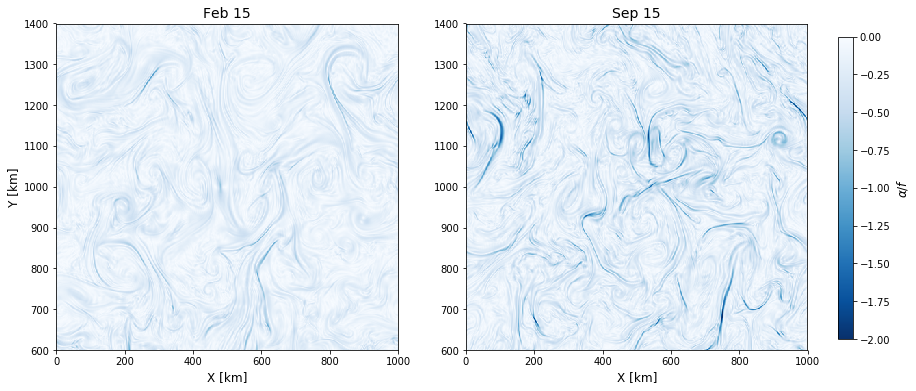

In [43]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
im = ax2.pcolormesh(strain.XC*1e-3, strain.YC.sel(YC=slice(6e5,14e5))*1e-3, 
                   (strain*(f0+beta*(dsday.YC-10e5))**-1).sel(YC=slice(6e5,14e5))[-24:,1][3],
                   vmax=0, vmin=-2, cmap='Blues_r', rasterized=True)

ax1.pcolormesh(strain.XC*1e-3, strain.YC.sel(YC=slice(6e5,14e5))*1e-3, 
              (strain*(f0+beta*(dsday.YC-10e5))**-1).sel(YC=slice(6e5,14e5))[-24:,1][17],
              vmax=0, vmin=-2, cmap='Blues_r', rasterized=True)

ax1.set_ylabel(r'Y [km]', fontsize=12)
ax1.set_xlabel(r'X [km]', fontsize=12)
# ax2.set_ylabel(r'Y [km]', fontsize=12)
ax2.set_xlabel(r'X [km]', fontsize=12)
ax1.set_title(r"Feb 15",fontsize=14)
ax2.set_title(r"Sep 15",fontsize=14)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\alpha/f$", fontsize=12)
plt.savefig(op.join(ddir,'../Figures/Strain_02km_snap_Feb-Sep.pdf'))

In [56]:
print(ampgradb.dims, Fs.dims)

('time', 'Zl', 'YC', 'XC') ('time', 'Z', 'YC', 'XC')


In [58]:
ampgradb.coords['day'] = ('time',np.tile(np.roll(range(25),-12),dy))
with ProgressBar():
    ampbd = ampgradb.groupby('day').mean(['time','YC','XC']).compute()

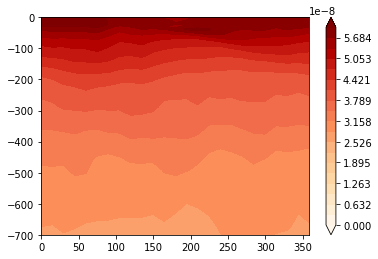

In [70]:
fig, ax = plt.subplots()
im = ax.contourf(np.linspace(0,359,25), ampbd.Zl, ampbd.T.roll(day=-12), 
                levels=1e-8*np.linspace(0,6.,20), 
                cmap='OrRd', extend='both')
ax.set_ylim([-7e2,0])
fig.colorbar(im, ax=ax)

In [20]:
# Fs = -(qs1*grid.interp(bx,'Z',boundary='fill') 
#       + qs2*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
#       )
# Fs.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
    Fs_normed = (grid.interp(ampgradb,'Z',boundary='fill')**-1 * Fs).compute()
# strain = xr.open_dataset(op.join(ddir,'zeta-strain-Fs_02kmrun.nc')).alpha * f0**-1
Fs_normed.coords['day'] = ('time',np.tile(np.roll(range(25),-12),dy))
Fs_normed

[########################################] | 100% Completed |  1min 50.6s


<xarray.DataArray (time: 25, Z: 76, YC: 1000, XC: 500)>
array([[[[ 2.042649e-27, ...,  5.217185e-28],
         ...,
         [-4.089644e-09, ..., -5.850374e-09]],

        ...,

        [[ 6.113615e-14, ...,  4.550194e-14],
         ...,
         [ 1.250702e-13, ..., -1.326763e-13]]],


       ...,


       [[[ 1.103140e-27, ...,  6.547180e-28],
         ...,
         [ 5.412685e-09, ...,  7.920236e-09]],

        ...,

        [[-7.040576e-14, ..., -7.947236e-14],
         ...,
         [ 3.368437e-13, ...,  8.870134e-14]]]])
Coordinates:
  * time     (time) float64 1.4e+08 1.413e+08 1.426e+08 1.439e+08 1.452e+08 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
    rA       (YC, XC) >f4 4000000.0 4000000.0 4000000.0 4000000.0 4000000.0 ...
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

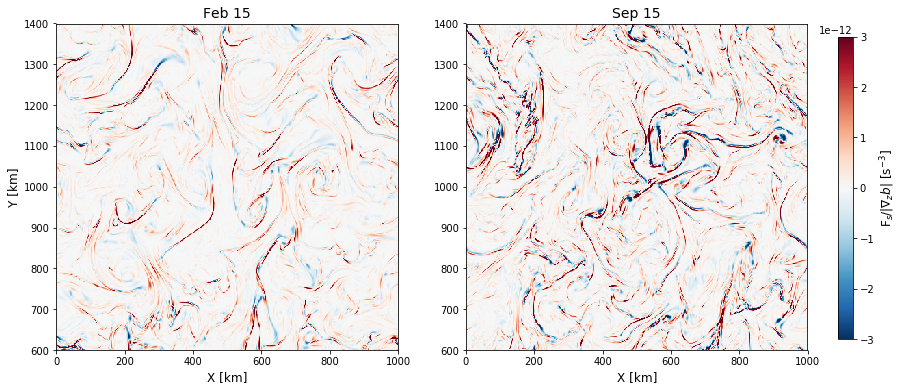

In [32]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
im = ax2.pcolormesh(Fs_normed.XC*1e-3, Fs_normed.YC.sel(YC=slice(6e5,14e5))*1e-3, Fs_normed.sel(YC=slice(6e5,14e5))[-24:,1][3],
                   vmax=3e-12, vmin=-3e-12, cmap='RdBu_r', rasterized=True)

ax1.pcolormesh(Fs_normed.XC*1e-3, Fs_normed.YC.sel(YC=slice(6e5,14e5))*1e-3, Fs_normed.sel(YC=slice(6e5,14e5))[-24:,1][17],
              vmax=3e-12, vmin=-3e-12, cmap='RdBu_r', rasterized=True)

ax1.set_ylabel(r'Y [km]', fontsize=12)
ax1.set_xlabel(r'X [km]', fontsize=12)
# ax2.set_ylabel(r'Y [km]', fontsize=12)
ax2.set_xlabel(r'X [km]', fontsize=12)
ax1.set_title(r"Feb 15",fontsize=14)
ax2.set_title(r"Sep 15",fontsize=14)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"F$_s/|\nabla_zb|$ [s$^{-3}$]", fontsize=12)
plt.savefig(op.join(ddir,'../Figures/Fs_02km_snap_Feb-Sep.pdf'))

In [36]:
Fs_normed.coords['seas'] = ('time',np.append(np.tile(np.repeat(np.roll(range(4),-2),6),dy),1))
grouped = (Fs_normed[:,0].sel(YC=slice(6e5,14e5))).groupby('seas')
da = xr.DataArray(np.zeros((4,6*dy,400,500)), dims=['seas','time','YC','XC'],
                  coords={'seas':range(4),'time':range(6*dy),
                         'YC':Fs_normed.sel(YC=slice(6e5,14e5)).YC.data,'XC':Fs_normed.XC.data}
                 )
i = 0
for group in grouped:
#     print(group)
    da[i] = group[1].data
    i += 1
da

<xarray.DataArray (seas: 4, time: 6, YC: 400, XC: 500)>
array([[[[-1.208944e-08, ..., -8.390623e-09],
         ...,
         [-9.234046e-09, ...,  9.431326e-10]],

        ...,

        [[-6.362398e-09, ..., -3.623379e-09],
         ...,
         [-6.583018e-09, ..., -1.512381e-09]]],


       ...,


       [[[ 2.345761e-09, ..., -3.121874e-08],
         ...,
         [ 3.061501e-09, ..., -1.600806e-09]],

        ...,

        [[-8.498775e-10, ..., -1.381841e-08],
         ...,
         [-2.720740e-08, ..., -1.417940e-08]]]])
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * time     (time) int64 0 1 2 3 4 5
  * YC       (YC) >f4 601000.0 603000.0 605000.0 607000.0 609000.0 611000.0 ...
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


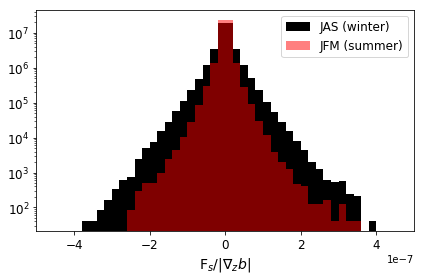

In [39]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)
ax.hist(da[2].data.ravel(), color='black', alpha=1., bins=50, range=(-5e-7,5e-7), 
        log=True, density=True, label='JAS (winter)')
ax.hist(da[0].data.ravel(), color='red', alpha=.5, bins=50, range=(-5e-7,5e-7),
        log=True, density=True, label='JFM (summer)')
ax.set_xlabel(r"F$_s/|\nabla_zb|$", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.set_xlim([-5e-7,5e-7])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'../Figures/Fs_histogram_02km.pdf'))

In [21]:
with ProgressBar():
    Fsd = Fs_normed.groupby('day').mean(['time','YC','XC']).compute()
Fsd

<xarray.DataArray (day: 25, Z: 76)>
array([[ 5.215035e-10,  7.875993e-14,  7.769881e-14, ...,  9.357140e-16,
         7.954516e-16, -2.189650e-14],
       [ 5.936272e-10,  8.023171e-14,  7.925543e-14, ...,  9.105283e-16,
         6.727404e-16, -2.111799e-14],
       [ 5.723974e-10,  7.649465e-14,  7.575870e-14, ...,  9.365607e-16,
         7.488900e-16, -1.844372e-14],
       ...,
       [ 5.100538e-10,  8.510702e-14,  8.384808e-14, ...,  9.298457e-16,
         6.522418e-16, -1.985255e-14],
       [ 5.150195e-10,  7.947042e-14,  7.832787e-14, ...,  1.026460e-15,
         6.953765e-16, -2.152923e-14],
       [ 5.177808e-10,  7.353975e-14,  7.265369e-14, ...,  8.931045e-16,
         5.619598e-16, -1.871922e-14]])
Coordinates:
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

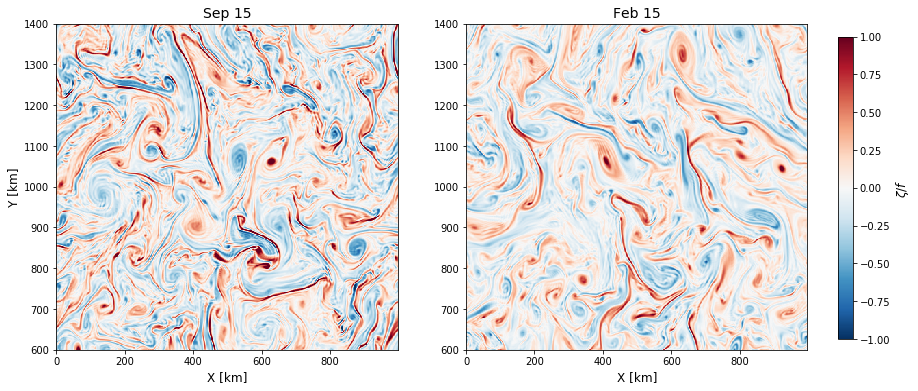

In [312]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
im = ax1.pcolormesh(zeta.XG*1e-3, zeta.YG.sel(YG=slice(6e5,14e5))*1e-3, 
                   zeta[-24:][5,0].sel(YG=slice(6e5,14e5))*(f0+beta*(dsday.YG.sel(YG=slice(6e5,14e5))-10e5))**-1,
                   vmax=1e0, vmin=-1e0, cmap='RdBu_r', rasterized=True)

ax2.pcolormesh(zeta.XG*1e-3, zeta.YG.sel(YG=slice(6e5,14e5))*1e-3, 
              zeta[-24:][15,0].sel(YG=slice(6e5,14e5))*(f0+beta*(dsday.YG.sel(YG=slice(6e5,14e5))-10e5))**-1,
              vmax=1e0, vmin=-1e0, cmap='RdBu_r', rasterized=True)

ax1.set_ylabel(r'Y [km]', fontsize=12)
ax1.set_xlabel(r'X [km]', fontsize=12)
# ax2.set_ylabel(r'Y [km]', fontsize=12)
ax2.set_xlabel(r'X [km]', fontsize=12)
ax2.set_title(r"Feb 15",fontsize=14)
ax1.set_title(r"Sep 15",fontsize=14)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\zeta/f$", fontsize=12)
plt.savefig(op.join(ddir,'../Figures/zeta_02km_snap_Feb-Sep.pdf'))

In [112]:
# zeta.coords['seas'] = ('time',np.append(np.tile(np.repeat(np.roll(range(4),-2),6),dy),1))
zeta[:-1].coords['seas'] = ('time',np.tile(np.repeat(np.roll(range(4),-2),6),dy))
grouped = (zeta[:-1,0].sel(YG=slice(6e5,14e5))*(f0+beta*(dsday.YG.sel(YG=slice(6e5,14e5))-10e5))**-1).groupby('seas')
da = xr.DataArray(np.zeros((4,6*dy,401,500)), dims=['seas','time','YG','XG'],
                  coords={'seas':range(4),'time':range(6*dy),
                         'YG':zeta.YG.sel(YG=slice(6e5,14e5)).data,'XG':zeta.XG.data}
                 )
i = 0
for group in grouped:
#     print(group)
    da[i] = group[1].data
    i += 1
da

<xarray.DataArray (seas: 4, time: 6, YG: 401, XG: 500)>
array([[[[-0.335918, ..., -0.151258],
         ...,
         [ 0.133309, ...,  0.238351]],

        ...,

        [[ 0.139499, ...,  0.003557],
         ...,
         [-0.035258, ..., -0.070625]]],


       ...,


       [[[ 0.038732, ...,  0.01166 ],
         ...,
         [ 0.027288, ...,  0.057576]],

        ...,

        [[ 0.206516, ...,  0.003587],
         ...,
         [-0.266099, ..., -0.272491]]]])
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * time     (time) int64 0 1 2 3 4 5
  * YG       (YG) float32 600000.0 602000.0 604000.0 606000.0 608000.0 ...
  * XG       (XG) float32 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


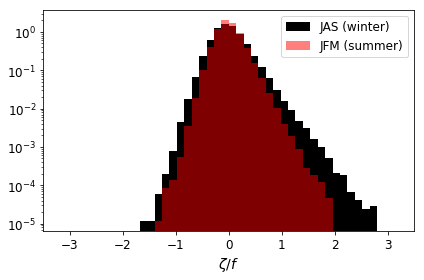

In [104]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)
ax.hist(da[2].data.ravel(), color='black', alpha=1., bins=50, range=(-3.5,3.5), 
        log=True, density=True, label='JAS (winter)')
ax.hist(da[0].data.ravel(), color='red', alpha=.5, bins=50, range=(-3.5,3.5),
        log=True, density=True, label='JFM (summer)')
ax.set_xlabel(r"$\zeta$/$f$", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.set_xlim([-3.5,3.5])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'../Figures/zeta_histogram_02km.pdf'))

In [133]:
zeta5 = xr.open_dataset('/swot/SUM05/takaya/MITgcm/channel/runs/zeta-strain-Fs_05kmrun.nc', decode_times=False).zeta
zeta20 = xr.open_dataset('/swot/SUM05/takaya/MITgcm/channel/runs/zeta-Fs_20kmrun.nc', decode_times=False).zeta

zeta5.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),20))
grouped = (zeta5[:,0].sel(YG=slice(6e5,14e5))*(f0+beta*(zeta5.YG.sel(YG=slice(6e5,14e5))-10e5))**-1).groupby('seas')
da5 = xr.DataArray(np.zeros((4,6*20,161,200)), dims=['seas','time','YG','XG'],
                   coords={'seas':range(4),'time':range(6*20),
                          'YG':zeta5.YG.sel(YG=slice(6e5,14e5)).data,'XG':zeta5.XG.data}
                   )
i = 0
for group in grouped:
#     print(group)
    da5[i] = group[1].data
    i += 1

zeta20.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),20))
grouped = (zeta20[:,0].sel(YG=slice(6e5,14e5))*(f0+beta*(zeta20.YG.sel(YG=slice(6e5,14e5))-10e5))**-1).groupby('seas')
da20 = xr.DataArray(np.zeros((4,6*20,41,50)), dims=['seas','time','YG','XG'],
                   coords={'seas':range(4),'time':range(6*20),
                          'YG':zeta20.YG.sel(YG=slice(6e5,14e5)).data,'XG':zeta20.XG.data}
                   )
i = 0
for group in grouped:
#     print(group)
    da20[i] = group[1].data
    i += 1
da

<xarray.DataArray (seas: 4, time: 6, YG: 401, XG: 500)>
array([[[[-0.335918, ..., -0.151258],
         ...,
         [ 0.133309, ...,  0.238351]],

        ...,

        [[ 0.139499, ...,  0.003557],
         ...,
         [-0.035258, ..., -0.070625]]],


       ...,


       [[[ 0.038732, ...,  0.01166 ],
         ...,
         [ 0.027288, ...,  0.057576]],

        ...,

        [[ 0.206516, ...,  0.003587],
         ...,
         [-0.266099, ..., -0.272491]]]])
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * time     (time) int64 0 1 2 3 4 5
  * YG       (YG) float32 600000.0 602000.0 604000.0 606000.0 608000.0 ...
  * XG       (XG) float32 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


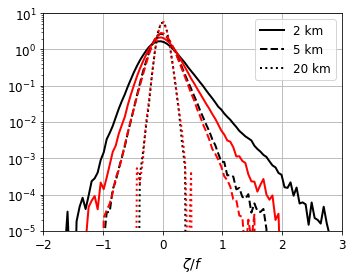

In [139]:
fig, ax = plt.subplots(figsize=(5,4))
fig.set_tight_layout(True)
ax.plot(np.linspace(-2,3,100), gaussian_kde(da[2].data.ravel())(np.linspace(-2,3,100)), 
       'k', lw=2, label='2 km')
ax.plot(np.linspace(-2,3,100), gaussian_kde(da[0].data.ravel())(np.linspace(-2,3,100)), 'r', lw=2)

ax.plot(np.linspace(-2,3,100), gaussian_kde(da5[2].data.ravel())(np.linspace(-2,3,100)), 
       'k--', lw=2, label='5 km')
ax.plot(np.linspace(-2,3,100), gaussian_kde(da5[0].data.ravel())(np.linspace(-2,3,100)), 'r--', lw=2)

ax.plot(np.linspace(-2,3,100), gaussian_kde(da20[2].data.ravel())(np.linspace(-2,3,100)), 
       'k:', lw=2, label='20 km')
ax.plot(np.linspace(-2,3,100), gaussian_kde(da20[0].data.ravel())(np.linspace(-2,3,100)), 'r:', lw=2)
ax.set_yscale('log')
ax.set_ylim([1e-5,1e1])
ax.set_xlim([-2,3])
ax.set_xlabel(r"$\zeta$/$f$", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
# ax.set_xlim([-3.5,3.5])
ax.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'../Figures/zeta_histogram_res-comp.pdf'))

In [22]:
# hbl = open_mdsdataset(op.join(ddir,'runs'), 
# #                       grid_dir=op.join(ddir,'02km_grid'),
#                      iters=range(ts+2160,te+2160,2160), prefix=['KPPhbl'], delta_t=dt
#                      ).KPPhbl
# hbl99 = xr.DataArray(np.percentile(hbl, 99, axis=-1), dims=['time','YC'],
#                     coords={'time':hbl.time,'YC':hbl.YC})
# hbl99.coords['day'] = ('time',np.tile(range(360),dy))
# hbl99.coords['seas'] = ('time',np.tile(np.repeat(np.roll(range(4),-2),90),dy))
# hbl99.coords['month'] = ('time',np.tile(np.repeat(np.roll(range(12),-6),30),dy))
# hbl99.to_dataset(name='hbl99').to_netcdf(op.join(ddir,'KPPhbl_99percentile_02km.nc'))
hbl99 = xr.open_dataset(op.join(ddir,'KPPhbl_99percentile_02km.nc')).hbl99
with ProgressBar():
    hbl99_day = hbl99.groupby('day').mean('time').compute()
#     hbl99_sea = hbl99.groupby('seas').mean('time').compute()
#     hbl99_mon = hbl99.groupby('month').mean('time').compute()
hbl99_day

<xarray.DataArray 'hbl99' (day: 360, YC: 1000)>
array([[   0.      ,  856.019467,  804.671083, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      ,  873.392276,  806.288749, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      ,  904.832932,  813.162896, ...,   30.      ,   30.      ,
          30.      ],
       ...,
       [   0.      , 1162.911127, 1046.628356, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      , 1169.172312, 1042.79228 , ...,   30.      ,   30.      ,
          30.      ],
       [   0.      , 1156.04707 ,  997.990954, ...,   30.      ,   30.      ,
          30.      ]])
Coordinates:
  * YC       (YC) float32 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [344]:
wpbpd

<xarray.DataArray (day: 24, Zl: 76)>
array([[ 2.825602e-08,  2.758085e-10,  6.231970e-10, ...,  1.161548e-09,
         7.371506e-10,  6.543920e-10],
       [ 2.075252e-09,  2.471514e-10,  5.538989e-10, ...,  2.318899e-09,
         1.404544e-09,  1.067507e-09],
       [ 1.315115e-08,  2.939468e-10,  6.926041e-10, ...,  1.824497e-09,
         1.064811e-09,  8.482013e-10],
       ...,
       [ 3.046620e-09,  4.864973e-10,  1.088197e-09, ...,  1.418049e-09,
         8.552785e-10,  6.950055e-10],
       [ 2.389754e-08,  3.983714e-10,  9.042765e-10, ...,  1.434102e-09,
         8.009831e-10,  6.237008e-10],
       [-2.009449e-08,  3.069382e-10,  6.978990e-10, ...,  2.512446e-09,
         1.285829e-09,  8.386566e-10]], dtype=float32)
Coordinates:
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

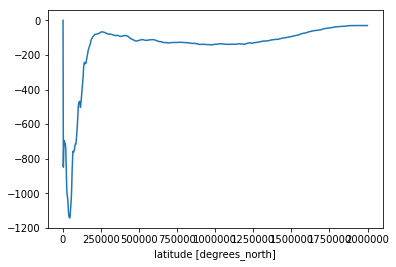

In [9]:
(-hbl99.mean(['time'])).plot()

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


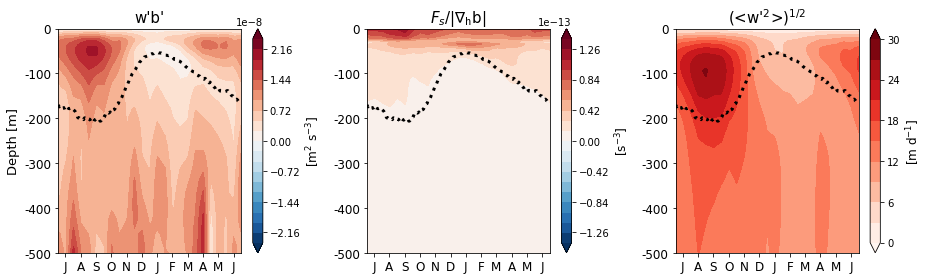

In [23]:
nys, nyn = (6e5,14e5)
month = ['J','F','M','A','M','J','J','A','S','O','N','D']

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(13,4))
fig.set_tight_layout(True)
im1 = ax1.contourf(np.linspace(0,359,25), wpbpd.Zl, wpbpd.T.roll(day=-12), 
                  levels=1e-8*np.linspace(-2.4,2.4,21), 
                   extend='both', cmap='RdBu_r')
# ax1.contourf(np.linspace(14,359,24), wpbpd.Zl, wpbpd.T.roll(day=-13), 
#             levels=1e-8*np.linspace(-2.4,2.4,21), 
#             extend='both', cmap='RdBu_r')
im2 = ax2.contourf(np.linspace(0,359,25), Fsd.Z, Fsd.T.roll(day=-12), 
                  levels=1e-13*np.linspace(-1.4,1.4,21), 
                  cmap='RdBu_r', extend='both')
# ax2.contourf(np.linspace(14,359,24), Fsd.Z, Fsd.T.roll(day=-13), 
#             levels=1e-13*np.linspace(-1.4,1.4,21), 
#             cmap='RdBu_r', extend='both')
im3 = ax3.contourf(np.linspace(0,359,25), w2sqrt.Zl, w2sqrt.T.roll(day=-12), 
                  levels=1e1*np.linspace(0,3.,11), 
                  cmap='Reds', extend='both')
# ax3.contourf(np.linspace(14,359,24), w2sqrt.Zl, w2sqrt.T.roll(day=-13), 
#             levels=1e1*np.linspace(0,3.,11), 
#             cmap='Reds', extend='both')
ax1.plot(range(360), -hbl99_day.sel(YC=slice(nys,nyn)).mean(['YC']).roll(day=-0), 
        ls=':', lw=3, color='k')
ax2.plot(range(360), -hbl99_day.sel(YC=slice(nys,nyn)).mean(['YC']).roll(day=-0), 
        ls=':', lw=3, color='k')
ax3.plot(range(360), -hbl99_day.sel(YC=slice(nys,nyn)).mean(['YC']).roll(day=-0), 
        ls=':', lw=3, color='k')
ax1.set_ylim([-5e2,0])
ax1.set_xlim([0.,359.])
ax2.set_ylim([-5e2,0])
ax2.set_xlim([0.,359.])
ax3.set_ylim([-5e2,0])
ax3.set_xlim([0.,359.])
ax1.set_title(r"w'b'", fontsize=15)
ax2.set_title(r"$F_s/|\nabla_{\tt h}$b$|$", fontsize=15)
ax3.set_title(r"(<w'$^2$>)$^{1/2}$", fontsize=15)
ax1.set_xticks(np.linspace(14,344,12))
ax1.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax2.set_xticks(np.linspace(14,344,12))
ax2.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax3.set_xticks(np.linspace(14,344,12))
ax3.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax1.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax2.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax3.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax1.set_ylabel(r"Depth [m]", fontsize=13)
# ax2.set_xlabel(r"Month", fontsize=13)
# fig.subplots_adjust(right=0.88)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar3 = fig.colorbar(im3, ax=ax3)
cbar1.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
cbar2.set_label(r"[s$^{-3}$]", fontsize=12)
cbar3.set_label(r"[m d$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'../Figures/wb-Fs-w2_02km.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/contour.py:1543: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


Text(0.5,1,'JAS/JFM')

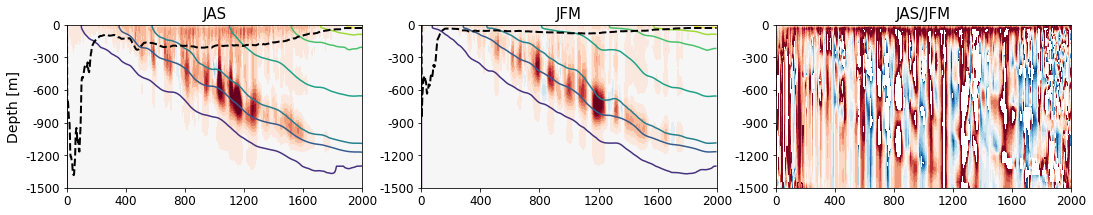

In [74]:
hbl99_sea = hbl99.groupby('seas').mean('time')

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,3))
im = ax1.contourf(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[2],
                 levels=np.linspace(-5e-8,5e-8,20), cmap='RdBu_r', extend='both')
ax1.contour(dmsea.YC*1e-3, dmsea.Z, dmsea.Ttave[2], 
           levels=np.linspace(-1,8,10))
# ax1.plot(MLD_seas.YC*1e-3, -MLD_seas[2], 'k', lw=2)
ax1.plot(hbl99_sea.YC*1e-3, -hbl99_sea[2], 'k--', lw=2)

ax2.contourf(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[0],
            levels=np.linspace(-5e-8,5e-8,20), cmap='RdBu_r', extend='both')
ax2.contour(dmsea.YC*1e-3, dmsea.Z, dmsea.Ttave[0], 
           levels=np.linspace(-1,8,10))

im3 = ax3.contourf(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[2]/wpbp_seas[0],
                  levels=np.logspace(-1,1,20), cmap='RdBu_r', norm=clr.LogNorm())
# ax2.plot(MLD_seas.YC*1e-3, -MLD_seas[0], 'k', lw=2)
ax2.plot(hbl99_sea.YC*1e-3, -hbl99_sea[0], 'k--', lw=2)
ax1.set_ylim([-1500,0])
ax2.set_ylim([-1500,0])
ax3.set_ylim([-1500,0])
ax1.set_xticks(np.array([0,400,800,1200,1600,2000]))
ax2.set_xticks(np.array([0,400,800,1200,1600,2000]))
ax3.set_xticks(np.array([0,400,800,1200,1600,2000]))
ax1.set_xticklabels(np.array([0,400,800,1200,1600,2000]), fontsize=12)
ax2.set_xticklabels(np.array([0,400,800,1200,1600,2000]), fontsize=12)
ax3.set_xticklabels(np.array([0,400,800,1200,1600,2000]), fontsize=12)
ax1.set_yticks(np.array([-1500,-1200,-900,-600,-300,0]))
ax2.set_yticks(np.array([-1500,-1200,-900,-600,-300,0]))
ax3.set_yticks(np.array([-1500,-1200,-900,-600,-300,0]))
ax1.set_yticklabels(np.array([-1500,-1200,-900,-600,-300,0]), fontsize=12)
ax2.set_yticklabels(np.array([-1500,-1200,-900,-600,-300,0]), fontsize=12)
ax3.set_yticklabels(np.array([-1500,-1200,-900,-600,-300,0]), fontsize=12)
ax1.set_ylabel(r'Depth [m]', fontsize=14)
ax1.set_xlabel(r'Y [km]', fontsize=14)
ax2.set_xlabel(r'Y [km]', fontsize=14)
ax3.set_xlabel(r'Y [km]', fontsize=14)
ax1.set_title(r"JAS",fontsize=15)
ax2.set_title(r"JFM",fontsize=15)
ax3.set_title(r"JAS/JFM",fontsize=15)
# fig.subplots_adjust(left=0.2, right=0.8, hspace=0.3)
# cbar_ax = fig.add_axes([0.86, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.linspace(-1e-7,1e-7,9))
# cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
# plt.savefig(op.join(ddir,'Figures/wb_02km_seasclim_JFM-JAS_3cols.pdf'))

In [27]:
with ProgressBar():
    uk2 = xrft.power_spectrum(grid.interp(up,'X').sel(YC=slice(6e5,14e5)).chunk(chunks={'XC':500}),
                             dim=['XC'], detrend='constant').compute()
    vk2 = xrft.power_spectrum(grid.interp(vp,'Y',boundary='fill').sel(YC=slice(6e5,14e5)
                                                                     ).chunk(chunks={'XC':500}),
                             dim=['XC'], detrend='constant').compute()

ekek = uk2 + vk2
ekek

[                                        ] | 0% Completed |  0.1s

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed | 32.6s


/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed | 31.2s


<xarray.DataArray (time: 25, Z: 76, YC: 400, freq_XC: 500)>
array([[[[7.717813e-04, ..., 3.078327e-03],
         ...,
         [2.300303e-05, ..., 1.391780e-03]],

        ...,

        [[1.197815e-07, ..., 3.223660e-08],
         ...,
         [1.767150e-05, ..., 5.537774e-06]]],


       ...,


       [[[3.518967e-04, ..., 2.474309e-04],
         ...,
         [6.215251e-05, ..., 2.554928e-05]],

        ...,

        [[1.857271e-07, ..., 6.999808e-06],
         ...,
         [2.121925e-06, ..., 5.564987e-08]]]])
Coordinates:
  * time             (time) float64 1.4e+08 1.413e+08 1.426e+08 1.439e+08 ...
  * Z                (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 ...
  * YC               (YC) >f4 601000.0 603000.0 605000.0 607000.0 609000.0 ...
  * freq_XC          (freq_XC) float64 -0.00025 -0.000249 -0.000248 ...
    freq_XC_spacing  float64 1e-06

In [28]:
seas = ('time',np.tile(np.append(np.repeat(np.roll(range(4),-2),6),dy),1))
ekek.coords['seas'] = seas
ekek.to_dataset(name='eke').to_netcdf(op.join(ddir,'EKEk_02kmrun.nc'))

In [39]:
pdir = '/swot/SUM05/takaya/MITgcm/channel/runs/'
ekek02 = xr.open_dataset(op.join(ddir, 'EKEk_02kmrun.nc')).eke
ekek05 = xr.open_dataset(op.join(pdir, 'EKEk_05kmrun.nc')).eke
ekek20 = xr.open_dataset(op.join(pdir, 'EKEk_20kmrun.nc')).eke
# ds2 = xr.open_dataset(op.join(avisodir, 'JASON2_45-55S_100-150E_JFMekespectra.nc'))
# ds3 = xr.open_dataset(op.join(avisodir, 'JASON2_45-55S_100-150E_JASekespectra.nc'))
ekek02_seas = ekek02.groupby('seas').mean('time')
ekek05_seas = ekek05.groupby('seas').mean('time')
ekek20_seas = ekek20.groupby('seas').mean('time')
ds1 = xr.open_dataset('/swot/SUM05/takaya/AVISO/AVISO_EKEk_56-61S.nc')
eke_AVISO = ds1.eke.mean('latitude')
k_AVISO = ds1.kx.mean('lat')
N = eke_AVISO.shape
# jsn2JFM = ds2.JFM
# jsn2JAS = ds3.JAS
# kjsn = ds2.kr

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [40]:
seasAV = np.array([0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3])
eke_AVISO_yrs = eke_AVISO[:598]
print(eke_AVISO_yrs)
eke_AVISO_yrs.coords['DinY'] = ('days',np.tile(seasAV,23))
eke_AVISO_seas = eke_AVISO_yrs.groupby('DinY').mean('days')
eke_AVISO_seas

<xarray.DataArray 'eke' (days: 598, freq_longitude: 1440)>
array([[2.828993e-10, 3.929395e-10, 4.323431e-10, ..., 3.682711e-10,
        4.323431e-10, 3.929395e-10],
       [3.830729e-10, 3.834541e-10, 4.026887e-10, ..., 4.707198e-10,
        4.026887e-10, 3.834541e-10],
       [3.012153e-10, 4.933155e-10, 5.644254e-10, ..., 4.873114e-10,
        5.644254e-10, 4.933155e-10],
       ...,
       [1.438368e-08, 1.441389e-08, 1.470313e-08, ..., 1.737978e-08,
        1.470313e-08, 1.441389e-08],
       [2.569444e-09, 5.152211e-09, 3.922301e-09, ..., 3.279705e-09,
        3.922301e-09, 5.152211e-09],
       [2.535069e-09, 3.051711e-09, 2.951270e-09, ..., 2.936089e-09,
        2.951270e-09, 3.051711e-09]])
Coordinates:
  * days                    (days) int64 0 14 28 42 56 ... 8316 8330 8344 8358
  * freq_longitude          (freq_longitude) float64 -2.0 -1.997 ... 1.994 1.997
    freq_longitude_spacing  float64 ...


<xarray.DataArray 'eke' (DinY: 4, freq_longitude: 1440)>
array([[4.351772e-10, 4.315060e-10, 4.226446e-10, ..., 4.242275e-10,
        4.226446e-10, 4.315060e-10],
       [4.187558e-10, 4.180976e-10, 4.224793e-10, ..., 4.270869e-10,
        4.224793e-10, 4.180976e-10],
       [3.574422e-09, 3.623521e-09, 3.644584e-09, ..., 3.598471e-09,
        3.644584e-09, 3.623521e-09],
       [4.713173e-09, 4.724282e-09, 4.596361e-09, ..., 4.806354e-09,
        4.596361e-09, 4.724282e-09]])
Coordinates:
  * freq_longitude          (freq_longitude) float64 -2.0 -1.997 ... 1.994 1.997
    freq_longitude_spacing  float64 ...
  * DinY                    (DinY) int64 0 1 2 3

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


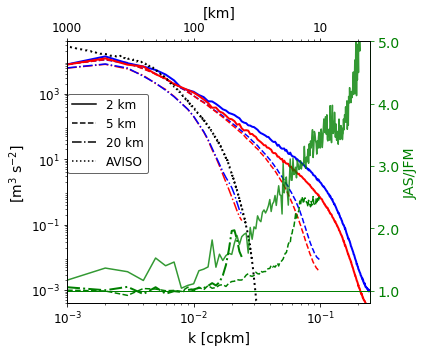

In [78]:
seasons = ['JFM','AMJ','JAS','OND']
colors = ['r','brown','b','g']
g = 9.8
trans = 1.

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
ax2 = ax.twinx()
ax3 = ax.twiny()
# ax.plot(ekek20.freq_XC[26:]*1e3, ekek20[:,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['time','YC']),
#        'k--', lw=1.5, label='20 km')
ax.plot(ekek20.freq_XC[26:]*1e3, ekek20_seas[0,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r-.', lw=1.5, alpha=trans, label='')
ax.plot(ekek20.freq_XC[26:]*1e3, ekek20_seas[2,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b-.', lw=1.5, alpha=trans, label='')

# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,0,:,100:].sel(YC=slice(10e5,12e5)).mean(['time','YC'])*ekek.freq_XC[100:]**-1,
#        'k--', lw=2, label='5 km')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[3,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
#        'g', lw=1, label='5 km (OND)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[1,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
#        color='brown', lw=1, label='5 km (AMJ)')
ax.plot(ekek05.freq_XC[101:]*1e3, ekek05_seas[2,0,:,101:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b--', lw=1.5, alpha=trans, label='')
ax.plot(ekek05.freq_XC[101:]*1e3, ekek05_seas[0,0,:,101:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r--', lw=1.5, alpha=trans, label='')

ax.plot(ekek02.freq_XC[251:]*1e3, ekek02_seas[2,0,:,251:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b', lw=2, alpha=trans, label='')
# ax.plot(ekek.freq_XC[251:]*1e3, ekek02_seas[3,0,:,251:].sel(YC=slice(6e5,14e5)).mean(['YC']),
#        'g', lw=2, alpha=trans, label='')
ax.plot(ekek02.freq_XC[251:]*1e3, ekek02_seas[0,0,:,251:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r', lw=2, alpha=trans, label='')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,39,:,100:].sel(YC=slice(6e5,14e5)).mean(['time','YC']),
#        color='k', lw=2, label='5 km (%3d m)' % -ekek.Z[39])
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[2,20,:,100:].sel(YC=slice(10e5,12e5)).mean(['YC'])*ekek.freq_XC[100:]**-1,
#        color='b', alpha=0.6, lw=2, label='5 km (540m)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[0,20,:,100:].sel(YC=slice(10e5,12e5)).mean(['YC'])*ekek.freq_XC[100:]**-1,
#        color='r', alpha=0.6, lw=2, label='5 km (540m)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,26,:,100:].sel(YC=slice(10e5,12e5)).mean(['time','YC'])*ekek.freq_XC[100:]**-1,
#        color='grey', lw=2, label='5 km (1040m)')

# ax.plot(kjsn[121:]*1e3, jsn2JFM.mean('nDATA')[121:]*kjsn*(g/np.abs(gsw.f(-50.)))**2, 
#         'r-.', lw=2, label=r"JASON2 (JFM)")
# ax.plot(kjsn[121:]*1e3, jsn2JAS.mean('nDATA')[121:]*kjsn*(g/np.abs(gsw.f(-50.)))**2, 
#         'b-.', lw=2, label=r"JASON2 (JFM)")
# ax.plot(k_AVISO[20:]*1e3, eke_AVISO[:,int(.5*N[1])+20:].mean('days').data*k_AVISO[20:]**-1,
#        'k:', lw=2, label='AVISO')
ax.plot(k_AVISO[20:]*1e3, eke_AVISO_seas.mean('DinY')[int(.5*N[1])+20:].data*k_AVISO[20:]**-1,
       'k:', lw=2, alpha=trans, label='')
ax.plot(np.zeros(0), 'k-', label='2 km')
ax.plot(np.zeros(0), 'k--', label='5 km')
ax.plot(np.zeros(0), 'k-.', label='20 km')
ax.plot(np.zeros(0), 'k:', label='AVISO')
# ax.plot(k_AVISO[20:]*1e3, eke_AVISO_seas[0,int(.5*N[1])+20:].data*k_AVISO[20:]**-1,
#        'r:', lw=1., alpha=trans, label='AVISO (JFM)')

ax2.plot(ekek20.freq_XC[26:]*1e3, (ekek20_seas[2,0,:,26:]/ekek20_seas[0,0,:,26:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
        '-.', color='g', lw=2, label='20 km', alpha=1.)
ax2.plot(ekek05.freq_XC[101:]*1e3, (ekek05_seas[2,0,:,101:]
                                   /ekek05_seas[0,0,:,101:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
        '--', color='g', lw=1.5, label='5 km', alpha=1.)
im, = ax2.plot(ekek02.freq_XC[251:]*1e3, (ekek02_seas[2,0,:,251:]
                                         /ekek02_seas[0,0,:,251:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
              '-', color='g', lw=1.5, label='2 km', alpha=.8)
# ax2.plot(k_AVISO[20:-50][::5]*1e3, (eke_AVISO_seas[2,int(.5*N[1])+20:-50]/eke_AVISO_seas[0,int(.5*N[1])+20:-50])[::5],
#         'g:', lw=1., label='AVISO', alpha=1.)
# ax2.plot(kjsn[121:]*1e3, (jsn2JAS.mean('nDATA') / jsn2JFM.mean('nDATA'))[121:], 
#          'g-.', lw=1., label='JASON2', alpha=1.)
ax2.plot(np.linspace(1e-3,5e-1,10), np.ones(10), 'g', lw=1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-3,2.5e-1])
ax.set_xticks([1e-3,1e-2,1e-1])
ax.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
ax.set_ylim([4e-4,4e4])
ax.set_yticks([1e-3,1e-1,1e1,1e3])
ax.set_yticklabels([1e-3,1e-1,1e1,1e3], fontsize=12)
ax3.set_xscale('log')
ax3.set_xlim([1e-3,2.5e-1])
ax3.set_xticks([1e-3,1e-2,1e-1])
ax3.set_xticklabels(np.asarray([1e3,1e2,1e1], dtype=int), fontsize=12)
ax.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax.get_yaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax2.set_xscale('log')
ax2.set_ylim([0.8,5.])
ax2.set_yticks([1.,2,3.,4,5.])
ax2.set_yticklabels([1.,2.,3.,4.,5.], fontsize=14)
ax2.spines["right"].set_edgecolor(im.get_color())
ax2.yaxis.label.set_color(im.get_color())
ax2.tick_params(axis='y', colors=im.get_color())
ax.set_xlabel(r'k [cpkm]', fontsize=14)
ax3.set_xlabel(r'[km]', fontsize=14)
ax.set_ylabel(r'[m$^3$ s$^{-2}$]', fontsize=14)
ax2.set_ylabel(r'JAS/JFM', fontsize=14)
# lg = ax.legend(loc='upper left', fontsize=12, framealpha=.6, frameon=1.)
lg = ax.legend(bbox_to_anchor=(0, .8), loc=2, borderaxespad=0., fontsize=12, framealpha=.6, frameon=1.)
# lg2 = ax2.legend(loc='upper right', fontsize=12, framealpha=.6, frameon=1.)
frame = lg.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
# frame2 = lg2.get_frame()
# frame2.set_color('white')
# frame2.set_edgecolor('black')
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label(r"[m$^3$ s$^{-2}$]", fontsize=12)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
plt.savefig(op.join(ddir,'../Figures/EKEkclim_MIT_AVISO.pdf'))

In [162]:
ekek.freq_XC[-210]**-1*1e-3
# ekek.freq_XC

<xarray.DataArray 'freq_XC' ()>
array(25.)
Coordinates:
    freq_XC          float64 4e-05
    freq_XC_spacing  float64 1e-06

In [39]:
nk25km = -210
dx = 1e3
# eke25 = (ekek[:,:,:,nk25km:]*ekek.freq_XC[nk25km]).sum('freq_XC')
eke25 = ekek[:,:,:,nk25km:].sum('freq_XC')

In [44]:
nz100 = 22
eke_zintg = ((eke25[:,:nz100]*dsmom.drF[:nz100]).sum('Z')
            ) * np.abs(dsmom.Zl[nz100])**-1
eke_zintg.coords['day'] = ('time',np.tile(np.roll(range(25),-12),dy))
eke_std = eke_zintg.sel(YC=slice(6e5,1.4e6)).groupby('day').std(['time','YC'])
eke_mean = eke_zintg.sel(YC=slice(6e5,1.4e6)).groupby('day').mean(['time','YC'])
eke_zintg

<xarray.DataArray (time: 25, YC: 400)>
dask.array<shape=(25, 400), dtype=float64, chunksize=(25, 400)>
Coordinates:
  * time             (time) float64 1.4e+08 1.413e+08 1.426e+08 1.439e+08 ...
  * YC               (YC) >f4 601000.0 603000.0 605000.0 607000.0 609000.0 ...
    freq_XC_spacing  float64 1e-06
    seas             (time) int64 2 2 2 2 2 2 3 3 3 3 3 3 0 0 0 0 0 0 1 1 1 ...
    Zl               >f4 -105.22
    day              (time) int64 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 ...

In [24]:
dsSF = open_mdsdataset(op.join(takadir,'02km_SF'), grid_dir=ddir,
                      iters=range(ts+64800,te+64800,64800), 
                      prefix=['SF30D'], delta_t=dt
                      )
dsSF

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM02/takaya/channelMOC-Darwin/02km_SF. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 12)
Coordinates:
  * XC       (XC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * XG       (XG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * YG       (YG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dxG      (YG, XC) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    dyG      (YC, XG) >f4 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    Depth    (YC, XC) 

In [46]:
wpbp_zintg = ((wpbpd[:,:nz100]*dsmom.drC[:nz100].data[np.newaxis,:]).sum('Zl')
             ) * np.abs(dsmom.Z[nz100])**-1
#              )
Fs_zintg = ((Fsd[:,:nz100]*dsmom.drF[:nz100].data[np.newaxis,:]).sum('Z')
           ) * np.abs(dsmom.Zl[nz100])**-1
#            )

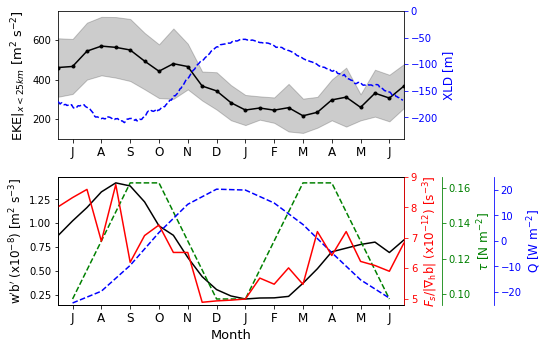

In [50]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, (ax1,ax3) = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
# fig.set_tight_layout(True)
ax2 = ax1.twinx()
# ax3 = ax.twinx()
ax4 = ax3.twinx()
ax5 = ax3.twinx()
ax6 = ax3.twinx()
# ax2.spines["left"].set_position(("axes", -.14))
# ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.11))
ax5.spines["right"].set_position(("axes", 1.26))
im1, = ax1.plot(range(0,375,15), eke_mean.roll(day=-12), 'k.-')
ax1.fill_between(range(0,375,15), (eke_mean-eke_std).roll(day=-12), 
               (eke_mean+eke_std).roll(day=-12), color='k', alpha=0.2)
im3, = ax3.plot(np.arange(0,375,15),
                wpbp_zintg.roll(day=-12)*1e8, 
                ls='-', color='k')
im2, = ax2.plot(range(360), -hbl99_day.sel(YC=slice(6e5,1.4e6)).mean(['YC']).roll(day=-0), 'b--')
im4, = ax4.plot(range(15,360,30), dsSF.oceTAUX.sel(YC=slice(6e5,1.4e6)).mean(['XG','YC']).roll(time=-0),
                'g--')
im5, = ax5.plot(range(15,360,30), dsSF.TFLUX.sel(YC=slice(6e5,1.4e6)).mean(['XC','YC']).roll(time=-0), 
                ls='--', color='b')
im6, = ax6.plot(np.arange(0,375,15),
                Fs_zintg.roll(day=-12)*1e12, 
                ls='-', color='r')

make_patch_spines_invisible(ax2)

# ax2.spines["left"].set_visible(True)
# ax2.yaxis.set_label_position('left')
# ax2.yaxis.set_ticks_position('left')

ax2.yaxis.label.set_color(im2.get_color())
ax3.yaxis.label.set_color(im3.get_color())
ax4.yaxis.label.set_color(im4.get_color())
ax5.yaxis.label.set_color(im5.get_color())
ax6.yaxis.label.set_color(im6.get_color())

ax2.spines["right"].set_edgecolor(im2.get_color())
ax3.spines["right"].set_edgecolor(im3.get_color())
ax4.spines["right"].set_edgecolor(im4.get_color())
ax5.spines["right"].set_edgecolor(im5.get_color())
ax6.spines["right"].set_edgecolor(im6.get_color())

ax2.tick_params(axis='y', colors=im2.get_color())
ax3.tick_params(axis='y', colors=im3.get_color())
ax4.tick_params(axis='y', colors=im4.get_color())
ax5.tick_params(axis='y', colors=im5.get_color())
ax6.tick_params(axis='y', colors=im6.get_color())
ax1.set_xticks(range(15,360,30))
ax1.set_xlim([0,360])
ax1.set_xticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],-6), fontsize=12)
ax3.set_xticks(range(15,360,30))
ax3.set_xlim([0,360])
ax3.set_xticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],-6), fontsize=12)
ax3.set_xlabel(r'Month', fontsize=13)
ax1.set_ylabel(r'EKE$|_{x<25km}$ [m$^2$ s$^{-2}$]', fontsize=13)
ax3.set_ylabel(r"w$'$b$'$ (x$10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=12)
ax2.set_ylabel(r'XLD [m]', fontsize=12)
ax4.set_ylabel(r'$\tau$ [N m$^{-2}$]', fontsize=12)
ax5.set_ylabel(r'Q [W m$^{-2}$]', fontsize=12)
ax6.set_ylabel(r"$F_s/|\nabla_{\tt h}{\tt b}|$ (x$10^{-12}$) [s$^{-3}$]", fontsize=12)
# ax1.set_ylim([.5,3.])
# ax2.set_ylim([1e-7,15e-7])
fig.subplots_adjust(right=0.6, left=0.2, bottom=0.2, hspace=0.3)
ax2.set_ylim([-240,0])
ax5.set_ylim([-25,25])
ax6.set_ylim([4.8,9])
plt.savefig(op.join(ddir,'../Figures/EKE_wb_XLD_tau_Q_02km.pdf'))

In [23]:
# wk = xrft.dft(w, dim=['XC'], shift=False)
# bk = xrft.dft(b, dim=['XC'], shift=False)
with ProgressBar():
    wkbkJAS = xrft.cross_spectrum(wp.sel(YC=slice(6e5,14e5))[12:18], bp.sel(YC=slice(6e5,14e5))[12:18],
                                 dim=['XC'], density=False, detrend='constant').mean(['time','YC']).compute()
    wkbkJFM = xrft.cross_spectrum(wp.sel(YC=slice(6e5,14e5))[:6], bp.sel(YC=slice(6e5,14e5))[:6],
                                 dim=['XC'], density=False, detrend='constant').mean(['time','YC']).compute()
#     wkbkJFM = (wk*np.conj(bk))[:6].sel(YC=slice(6e5,14e5)).real.mean(['time','YC']).compute()
# #     wkbkOND = (wk*np.conj(bk))[6:12].sel(YC=slice(6e5,14e5)).real.mean(['time','YC']).compute()
#     wkbkJAS = (wk*np.conj(bk))[12:18].sel(YC=slice(6e5,14e5)).real.mean(['time','YC']).compute()
wkbkJAS

[########################################] | 100% Completed | 24.5s
[########################################] | 100% Completed | 59.5s


<xarray.DataArray (Zl: 76, freq_XC: 200)>
array([[ 3.512213e-11, -1.541967e-11,  4.383132e-11, ...,  2.301816e-11,
         4.383132e-11, -1.541967e-11],
       [ 6.320918e-10,  6.823310e-10,  6.821785e-10, ...,  7.379560e-10,
         6.821785e-10,  6.823310e-10],
       [ 1.357839e-09,  1.462614e-09,  1.458555e-09, ...,  1.581339e-09,
         1.458555e-09,  1.462614e-09],
       ...,
       [-1.330006e-12, -3.350367e-12, -1.496685e-12, ...,  1.981736e-12,
        -1.496685e-12, -3.350367e-12],
       [-1.045878e-12, -3.929912e-13, -2.083295e-13, ...,  1.089154e-12,
        -2.083295e-13, -3.929912e-13],
       [-4.348895e-13, -1.259773e-13,  2.956866e-13, ..., -2.874444e-14,
         2.956866e-13, -1.259773e-13]])
Coordinates:
  * Zl               (Zl) >f4 0.0 -1.0 -2.14 ... -2562.59 -2689.32 -2825.33
  * freq_XC          (freq_XC) float64 -0.0001 -9.9e-05 ... 9.8e-05 9.9e-05
    freq_XC_spacing  float64 1e-06

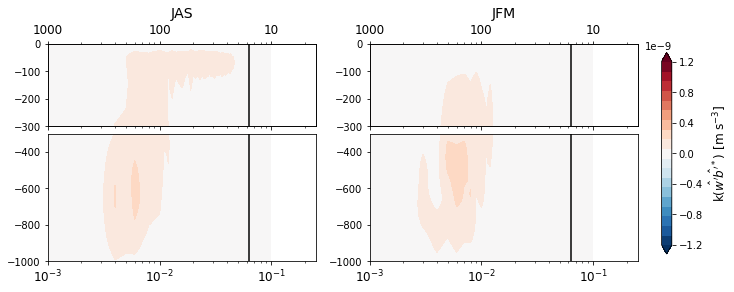

In [25]:
fig = plt.figure(figsize=(11,4))
gs = GS(5, 2)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0])
ax3 = fig.add_subplot(gs[:2,1])
ax4 = fig.add_subplot(gs[2:,1])
ax5 = ax1.twiny()
ax6 = ax3.twiny()
# fig.set_tight_layout(True)
im1 = ax1.contourf(wk.sel(freq_XC=slice(1e-6,wk.freq_XC.max())).freq_XC*1e3, wk.Zl, 
                  (wkbkJAS*wkbkJAS.freq_XC).sel(freq_XC=slice(1e-6,wk.freq_XC.max())),
                  cmap='RdBu_r', levels=1e-9*np.linspace(-1.2,1.2,20), extend='both')
im2 = ax2.contourf(wk.sel(freq_XC=slice(1e-6,wk.freq_XC.max())).freq_XC*1e3, wk.Zl, 
                (wkbkJAS*wkbkJAS.freq_XC).sel(freq_XC=slice(1e-6,wk.freq_XC.max())),
                cmap='RdBu_r', levels=1e-9*np.linspace(-1.2,1.2,20), extend='both')
ax1.plot(np.ones(5)*Rd**-1, np.linspace(-3e2,0,5), 'k')
ax2.plot(np.ones(5)*Rd**-1, np.linspace(-10e2,-3e2,5), 'k')
# im2 = ax2.contourf(wk.sel(freq_XC=slice(1e-6,wk.freq_XC.max())).freq_XC*1e3, wk.Zl, 
#                   (wkbkOND*wk.freq_XC).sel(freq_XC=slice(1e-6,wk.freq_XC.max())),
#                   cmap='RdBu_r', levels=1e-9*np.linspace(-1.2,1.2,20), extend='both')
im3 = ax3.contourf(wk.sel(freq_XC=slice(1e-6,wk.freq_XC.max())).freq_XC*1e3, wk.Zl, 
                  (wkbkJFM*wkbkJFM.freq_XC).sel(freq_XC=slice(1e-6,wk.freq_XC.max())),
                  cmap='RdBu_r', levels=1e-9*np.linspace(-1.2,1.2,20), extend='both')
im4 = ax4.contourf(wk.sel(freq_XC=slice(1e-6,wk.freq_XC.max())).freq_XC*1e3, wk.Zl, 
                (wkbkJFM*wkbkJFM.freq_XC).sel(freq_XC=slice(1e-6,wk.freq_XC.max())),
                cmap='RdBu_r', levels=1e-9*np.linspace(-1.2,1.2,20), extend='both')

for c in im1.collections:
    c.set_rasterized(True)
for c in im2.collections:
    c.set_rasterized(True)
for c in im3.collections:
    c.set_rasterized(True)
for c in im4.collections:
    c.set_rasterized(True)
    
ax3.plot(np.ones(5)*Rd**-1, np.linspace(-3e2,0,5), 'k')
ax4.plot(np.ones(5)*Rd**-1, np.linspace(-10e2,-3e2,5), 'k')
ax1.set_xscale('log')
ax1.set_xlim([1e-3,2.5e-1])
ax1.set_xticks([1e-3,1e-2,1e-1])
ax1.set_xticklabels([])
# ax1.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax2.set_xscale('log')
ax2.set_xlim([1e-3,2.5e-1])
ax2.set_xticks([1e-3,1e-2,1e-1])
ax2.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
ax2.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax1.set_ylim([-3e2,0])
ax2.set_ylim([-10e2,-3e2])
# ax2.set_xscale('log')
# ax2.set_xlim([1e-3,2.5e-1])
# ax2.set_xticks([1e-3,1e-2,1e-1])
# ax2.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
# ax2.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax3.set_xscale('log')
ax3.set_xlim([1e-3,2.5e-1])
ax3.set_xticks([1e-3,1e-2,1e-1])
ax3.set_xticklabels([])
# ax3.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax4.set_xscale('log')
ax4.set_xlim([1e-3,2.5e-1])
ax4.set_xticks([1e-3,1e-2,1e-1])
ax4.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
ax4.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax3.set_ylim([-3e2,0])
ax4.set_ylim([-10e2,-3e2])
ax1.set_title(r"JAS", fontsize=14)
# ax2.set_title(r"OND", fontsize=14)
ax3.set_title(r"JFM", fontsize=14)

ax5.set_xscale('log')
ax5.set_xlim([1e-3,2.5e-1])
ax5.set_xticks([1e-3,1e-2,1e-1])
ax5.set_xticklabels(np.asarray([1e3,1e2,1e1],dtype=int), fontsize=12)
ax6.set_xscale('log')
ax6.set_xlim([1e-3,2.5e-1])
ax6.set_xticks([1e-3,1e-2,1e-1])
ax6.set_xticklabels(np.asarray([1e3,1e2,1e1],dtype=int), fontsize=12)
# fig.set_tight_layout(True)
# im2 = ax2.contourf(wk.sel(freq_XC=slice(1e-6,wk.freq_XC.max())).freq_XC*1e3, wk.Zl, 
#                   (wkbkOND*wk.freq_XC).sel(freq_XC=slice(1e-6,wk.freq_XC.max())),
#                   cmap='RdBu_r', levels=1e-9*np.linspace(-1.2,1.2,20), extend='both')
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.013, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax, ticks=1e-9*np.array([-1.2,-.8,-.4,0,.4,.8,1.2]))
cbar.set_label(r"k$(\hat{w'} \hat{b'}^*)$ [m s$^{-3}$]", fontsize=12)
plt.savefig(op.join(takadir,'Figures/wkbk_seas_05km.pdf'))